In [131]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import sklearn


# Определение уязвимых групп населения

## Цели и задачи работы

1. кластеризовать регионы России и определить, какие из них наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения;

2. описать группы населения, сталкивающиеся с бедностью;

3. определить: 
- влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе;
- связаны ли уровень бедности/социального неблагополучия с производством и потреблением в регионе;
- какие ещё зависимости можно наблюдать относительно социально незащищённых слоёв населения.

## 1. Сбор данных

Так как в разных таблицах названия регионов даны по разному, предварительно необходимо написть функции для предобработки столбца с пеерчислением регионов.

In [132]:
# Функция удаляет лтшние пробелы, знаки переноса строки и приводит назвние к нижнему регистру.
# Так же функция заменяет значения не являющиеря регионами на np.nan
def index_nomalizer(ind: list) -> list:
    accep_list = ['край', 'обл', 'респуб', 'москв', 'авт', 'петерб', 'севаст']
    arch_flag = 0
    tum_flag = 0
    mosc_flag = 0
    mosc_obl_flag = 0
    for n in range(len(ind)):
        flag = 0
        ind[n] = ind[n].lower()
        
        if ('(' in ind[n]) and (')' in ind[n]):
            elem = re.search(r'\((.+)\)', ind[n])
            ind[n] = ind[n][:elem.start()] + ind[n][elem.end():] 
            
        ind[n] = ' '.join(ind[n].split())
        
        for elem in accep_list:
            if elem in ind[n]:
                flag = 1
        
        if ('арханг' in ind[n]):
            arch_flag += 1 
            if arch_flag > 1:
                flag = 0
            
        if ('тюмен' in ind[n]):
            tum_flag += 1
            if tum_flag > 1:
                flag = 0
                
        if ('москва' in ind[n]):
            mosc_flag += 1
            if mosc_flag > 1:
                flag = 0
                
        if ('московс' in ind[n]):
            mosc_obl_flag += 1
            if mosc_obl_flag > 1:
                flag = 0

        ind[n] = ind[n].replace('\n', ' ').replace('.', '')
        
        # if ('(' in ind[n]) and (')' in ind[n]):
        #     elem = re.search(r'\((.+)\)', ind[n])
        #     ind[n] = ind[n][:elem.start()] + ind[n][elem.end():]  
            
        # ind[n] = ' '.join(ind[n].split())
        
        if 'автономный' in ind[n]:
            ind[n] = ind[n].replace('автономный', 'авт')
          
        if not flag:
            ind[n] = np.nan
            
    # for n in range(len(ind)):
    #     if arch_flag > 1 and ind[n] is not np.nan:
    #         if ('арханг' in ind[n]) and not (('без' in ind[n]) or ('кроме' in ind[n])):
    #             ind[n] = np.nan 
              
    #     if tum_flag > 1 and ind[n] is not np.nan:
    #         if ('тюмен' in ind[n]) and not (('без' in ind[n]) or ('кроме' in ind[n])):
    #             ind[n] = np.nan
                
    return ind

In [133]:
# Функция удаляет лишние символы в наименовании регионов
def index_standartizer(ind: list) -> list:
    for n in range(len(ind)):     
        if ind[n] is np.nan:
            pass
        elif 'край' in ind[n]:
            elem = re.search('край', ind[n])
            ind[n] = ind[n][:elem.end()]
        elif 'обл'  in ind[n]:
            elem = re.search('обл', ind[n])
            ind[n] = ind[n][:elem.end()]
        elif 'округ'  in ind[n] and 'авт'in ind[n]:
            elem = re.search('округ', ind[n])
            ind[n] = ind[n][:elem.end()]
        elif 'респуб'  in ind[n]:
            splitted = ind[n].split(' ')
            ind[n] = splitted[0] + ' ' + splitted[1]
        elif 'москва'  in ind[n]:
            elem = re.search('москва', ind[n])
            ind[n] = ind[n][elem.start():elem.end()]
        elif 'севастополь'  in ind[n]:
            elem = re.search('севастополь', ind[n])
            ind[n] = ind[n][elem.start():elem.end()]
        elif 'санкт-петербург'  in ind[n]:
            elem = re.search('санкт-петербург', ind[n])
            ind[n] = ind[n][elem.start():elem.end()]
    return ind

Исходя из визуального анализа предложенных для анализа таблиц, можно сделать вывод, что наиболее полные данные у нас есть только за 2020 год. Во избежание изменений проблем с изменением учета статистических данных имеет смысл рассматривать данные за один и тот же год. Поэтому предлагаю сразу создавать датасет по даннным на 2020 год.

In [134]:
year = 2020

data_list = []

#б/н Среднедушевые денежные доходы (в месяц), руб.
per_capita_cash_income = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name='per_capita_cash_income')
per_capita_cash_income = per_capita_cash_income[['region', year]]
#0 Реальные денежные доходы, в процентах к предыдущему году
per_capita_cash_income_real_incomes = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name='real_incomes')
per_capita_cash_income_real_incomes = per_capita_cash_income_real_incomes[['region', year]].rename(columns={year: 'per_capita_cash_income_real_incomes'})
data_list.append(per_capita_cash_income_real_incomes)
#1 Среднемесячная номинальная начисленная заработная плата, руб
formal_wage_paid = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name='formal_wage_paid')
formal_wage_paid = formal_wage_paid[['region', year]].rename(columns={year: 'formal_wage_paid'})
data_list.append(formal_wage_paid)
#2 Реальная начисленная заработная плата, в процентах к предыдущему году
formal_wage_paid_real_pay = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name='real_pay')
formal_wage_paid_real_pay = formal_wage_paid_real_pay[['region', year]].rename(columns={year: 'formal_wage_paid_real_pay'})
data_list.append(formal_wage_paid_real_pay)

#3 Число умерших на первом году жизни детей за год (человек, значение показателя за год) сельское население
child_mortality_rural = pd.read_excel('data/child_mortality_rural_1990_2021.xls', sheet_name='Данные', header=2)
child_mortality_rural.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
child_mortality_rural.drop(['Unnamed: 1', 'Unnamed: 2'], inplace=True, axis=1)
child_mortality_rural = child_mortality_rural[['region', f'{year}']].rename(columns={f'{year}': 'child_mortality_rural'})
data_list.append(child_mortality_rural)


#4 Число умерших на первом году жизни детей за год (человек, значение показателя за год) городское население
child_mortality_urban = pd.read_excel('data/child_mortality_rural_1990_2021.xls', sheet_name='Данные', header=2)
child_mortality_urban.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
child_mortality_urban.drop(['Unnamed: 1', 'Unnamed: 2'], inplace=True, axis=1)
child_mortality_urban = child_mortality_urban[['region', f'{year}']].rename(columns={f'{year}': 'child_mortality_urban'})
data_list.append(child_mortality_urban)

#5 число людей с инвалидностью по регионам, по месяцам, по возрастным группам.
disabled_total_by_age =  pd.read_csv('data/disabled_total_by_age_2017_2022.csv')
disabled_total_by_age = disabled_total_by_age[(disabled_total_by_age['date'] >= f'{year}-01-01') & (\
    disabled_total_by_age['date'] <= f'{year}-12-01')].drop('date', axis=1).groupby('region').mean()
disabled_total_by_age['region'] = disabled_total_by_age.index
disabled_total_by_age.reset_index(drop=True, inplace=True)
data_list.append(disabled_total_by_age)

# drug_alco.xlsx исключаем за отсутствием статистики на 2020 год.

#6 валовой региональный продукт на душу населения, в рублях.
gross_regional_product = pd.read_excel('data/gross_regional_product_1996_2020.xls', sheet_name='Данные', header=2)
gross_regional_product.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
gross_regional_product = gross_regional_product[['region', f'{year}']].rename(columns={f'{year}': 'gross_regional_product'})
data_list.append(gross_regional_product)

#7 Характеристика жилищных условий домохозяйств, % от всех домохозяйств
housing_cond = pd.read_excel('data/housing_2020.xlsx', sheet_name='housing_cond')
housing_cond = housing_cond.drop('Число домохозяйств, проживающих во всех типах жилых помещений', axis=1)
housing_cond = housing_cond.drop('затруднились ответить', axis=1)
housing_cond = housing_cond.drop('в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности', axis=1)
housing_cond = housing_cond.drop('Размер общей площади в расчете на члена домохозяйства', axis=1)
housing_cond.rename(columns={'Регион': 'region'}, inplace=True)
# housing_cond = housing_cond.dropna(subset='region', axis=0)
data_list.append(housing_cond)
#8 Оценка домохозяйствами состояния занимаемого ими жилого помещения, % от всех домохозяйств
housing_intent = pd.read_excel('data/housing_2020.xlsx', sheet_name='housing_intent')
housing_intent = housing_intent.drop('Все домохозяйства', axis=1)
housing_intent = housing_intent.replace('...', np.nan)
housing_intent = housing_intent.replace('…*', np.nan)
housing_intent = housing_intent[housing_intent.columns[0:5]]
housing_intent.rename(columns={'Регион': 'region'}, inplace=True)
# housing_intent = housing_cond.dropna(subset='region', axis=0)
data_list.append(housing_intent)

# morbidity_2005_2020_age_disease.xls исключаем за отсутствием статистики на 2020 год.

#9 среднее число новорожденных в месяц.
newborn =  pd.read_csv('data/newborn_2006_2022_monthly.csv', sep=';', decimal=',')
cols = []
for elem in newborn.columns:
    if f'{year}' in elem:
        cols.append(elem)
cols

newborn = newborn[['Region', *cols]]
newborn['middle_newborn'] = newborn[[*cols]].mean(axis=1)
newborn.drop(cols, axis=1, inplace=True)
newborn.rename(columns={'Region': 'region'}, inplace=True)
data_list.append(newborn)

#10 численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг.
population = pd.read_excel('data/population.xlsx', sheet_name='Отчет')
population.rename(columns={'Unnamed: 0': 'region', f'23110000100030200002 Численность постоянного населения на 1 января.{str(year)[-2:]}': year}, inplace=True)
population.drop(['Unnamed: 1'], inplace=True, axis=1)
population.drop(index=0, inplace=True, axis=0)
population['region'] = population['region'].shift(1)
population[year] = population[year].astype(np.float64)
population = population[['region', year]].rename(columns={year: 'population'})
# population = population.dropna(subset='region', axis=0)
data_list.append(population)

#11 процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам.
poverty_percent_by_regions =  pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
poverty_percent_by_regions = poverty_percent_by_regions[poverty_percent_by_regions['year'] == year]
poverty_percent_by_regions.drop('year', axis=1, inplace=True)
data_list.append(poverty_percent_by_regions)


#12 распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2020 гг., по регионам.
poverty_socdem = pd.read_excel(f'data/poverty_socdem_{year}.xls', sheet_name='Данные', header=2)
poverty_socdem.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
poverty_socdem.drop('Все население', axis=1, inplace=True)
data_list.append(poverty_socdem)

#13 объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам
# деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).
regional_production =  pd.read_csv('data/regional_production_2017_2020.csv')
regional_production = regional_production[['region', 'production_field', f'{year}']]
regional_production = regional_production.pivot(index='region', columns='production_field', values=f'{year}')
regional_production['region'] = regional_production.index
regional_production.reset_index(drop=True, inplace=True)
data_list.append(regional_production)

#14 оборот розничной торговли на душу населения, в рублях.
retail_turnover_per_capita = pd.read_excel(f'data/retail_turnover_per_capita_2000_2021.xls', sheet_name='Данные', header=2)
retail_turnover_per_capita.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
retail_turnover_per_capita.drop('Unnamed: 1', axis=1, inplace=True)
retail_turnover_per_capita.drop(index=0, inplace=True, axis=0)
retail_turnover_per_capita[f'{year}'] = retail_turnover_per_capita[f'{year}'].astype(np.float64)
retail_turnover_per_capita = retail_turnover_per_capita[['region', f'{year}']].rename(columns={f'{year}': 'retail_turnover_per_capita'})
# retail_turnover_per_capita = retail_turnover_per_capita.dropna(subset='region', axis=0)
data_list.append(retail_turnover_per_capita)

#15 расходы на социальную политику от общих расходов бюджета региона, % в год
welfare_expense_share = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx', sheet_name='data')
welfare_expense_share = welfare_expense_share[['region', year]].rename(columns={year: 'welfare_expense_share'})
data_list.append(welfare_expense_share)

C:\Users\User\AppData\Local\Temp\ipykernel_10428\2848115504.py:64: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\User\AppData\Local\Temp\ipykernel_10428\2848115504.py:65: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



создаем датасет за 2020 год.

In [135]:
region = index_nomalizer(list(per_capita_cash_income['region']))
region = index_standartizer(region)

per_capita_cash_income['region'] = region


per_capita_cash_income.dropna(axis=0, inplace=True)
per_capita_cash_income.reset_index(drop=True, inplace=True)

data = per_capita_cash_income[['region', year]].rename(columns={year: 'per_capita_cash_income'})
data = data.set_index('region')

In [136]:
for n in range(len(data_list)):
    data_list[n] = data_list[n].dropna(subset='region', axis=0)
    region = index_nomalizer(list(data_list[n]['region']))
    region = index_standartizer(region)
    data_list[n]['region'] = region
    data_list[n] = data_list[n].dropna(subset='region', axis=0)
    data_list[n] = data_list[n].set_index('region')
    # data = data.merge(right=data_list[n], how='left', right_index =True, left_index=True)
    # data = data.groupby('region').mean()
    data = data.join(data_list[n], how='left', on='region', sort=True, rsuffix='_other')

C:\Users\User\AppData\Local\Temp\ipykernel_10428\2610834017.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_10428\2610834017.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



создаем датасет по претупности за 2020 год.

In [137]:
cols = ['region', 'несовершеннолетними или при их соучастии', 'ранее совершавшими преступления', 'в том числе ранее судимыми', 'группой лиц', \
    'группой лиц по предварительному сговору', 'организованной группой', 'преступным сообществом (преступной организацией)', \
        'в состоянии опьянения алкогольного', 'в состоянии опьянения наркотического', 'в состоянии опьянения токсического' ]

crime_list = []

# 0 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) Всего
crime_total = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 1', header=9)
crime_total.drop(columns=['Unnamed: 0'], inplace=True)
crime_total.drop(index=0, inplace=True)
cols_total = [f'{el} всего' for el in cols]
cols_total[0] = 'region'
crime_total.columns = cols_total
crime_list.append(crime_total)

# 1 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) особо тяжких
crime_especially_serious = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 2', header=9)
crime_especially_serious.drop(columns=['Unnamed: 0'], inplace=True)
crime_especially_serious.drop(index=0, inplace=True)
cols_especially_serious = [f'{el} особо тяжких' for el in cols]
cols_especially_serious[0] = 'region'
crime_especially_serious.columns = cols_especially_serious
crime_list.append(crime_especially_serious)

# 2 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) тяжких
crime_serious = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 3', header=9)
crime_serious.drop(columns=['Unnamed: 0'], inplace=True)
crime_serious.drop(index=0, inplace=True)
cols_serious = [f'{el} тяжких' for el in cols]
cols_serious[0] = 'region'
crime_serious.columns = cols_serious
crime_list.append(crime_serious)

# 3 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) средней тяжести
medium_gravity_crime = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 4', header=9)
medium_gravity_crime.drop(columns=['Unnamed: 0'], inplace=True)
medium_gravity_crime.drop(index=0, inplace=True)
cols_medium_gravity = [f'{el} средней тяжести' for el in cols]
cols_medium_gravity[0] = 'region'
medium_gravity_crime.columns = cols_medium_gravity
crime_list.append(medium_gravity_crime)

# 4 Сведения о преступлениях, совершенных отдельными категориями лиц (по расследованным преступлениям) небольшой тяжести
minor_crime = pd.read_excel(f'data/crimes/4-EGS_Razdel_4_122020.xls', sheet_name='Строка 5', header=9)
minor_crime.drop(columns=['Unnamed: 0'], inplace=True)
minor_crime.drop(index=0, inplace=True)
cols_minor = [f'{el} небольшой тяжести' for el in cols]
cols_minor[0] = 'region'
minor_crime.columns = cols_minor
crime_list.append(minor_crime)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [138]:
for n in range(len(crime_list)):
    crime_list[n] = crime_list[n].dropna(subset='region', axis=0)
    region = index_nomalizer(list(crime_list[n]['region']))
    region = index_standartizer(region)
    crime_list[n]['region'] = region
    crime_list[n] = crime_list[n].dropna(subset='region', axis=0)
    for col in crime_list[n].columns[1:]:
        if crime_list[n][col].dtype is np.dtype('O'):
            crime_list[n][col] = crime_list[n][col].astype('float64')
    # crime_data = crime_data.join(data_list[n], how='left', on='region', sort=True, rsuffix='_other')

C:\Users\User\AppData\Local\Temp\ipykernel_10428\2763981922.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_10428\2763981922.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\AppData\Local\Temp\ipykernel_10428\2763981922.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [139]:
crime_data = crime_list[0]
for n in range(len(crime_list)-1):
    crime_list[n+1] = crime_list[n+1].set_index('region')
    crime_data = crime_data.join(crime_list[n+1], how='left', on='region', sort=True, rsuffix='_other')
crime_data.set_index('region', inplace=True)


## 2. Предобработка и очистка данных

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, алтайский край to ярославская обл
Columns: 162 entries, per_capita_cash_income to welfare_expense_share
dtypes: float64(162)
memory usage: 108.2+ KB


Так как известно, что все данные числовые, проверим их на отсутствие пропусков.

In [141]:
for n in range(len(data_list)):
    if data_list[n].isna().sum().sum() !=0:
        print(f'датасет № {n} всего пропусков: {data_list[n].isna().sum().sum()}\n')
        display(data_list[n].info())

датасет № 3 всего пропусков: 2

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, белгородская обл to чеченская и
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   child_mortality_rural  85 non-null     float64
dtypes: float64(1)
memory usage: 1.4+ KB


None

датасет № 4 всего пропусков: 2

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, белгородская обл to чеченская и
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   child_mortality_urban  85 non-null     float64
dtypes: float64(1)
memory usage: 1.4+ KB


None

датасет № 9 всего пропусков: 1

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, белгородская обл to чукотский авт округ
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   middle_newborn  85 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


None

датасет № 10 всего пропусков: 1

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, белгородская обл to чукотский авт округ
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   population  85 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


None

датасет № 12 всего пропусков: 36

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, белгородская обл to чукотский авт округ
Data columns (total 3 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Дети в возрасте до 16 лет                  73 non-null     float64
 1   Население старше трудоспособного возраста  73 non-null     float64
 2   Население трудоспособного возраста         73 non-null     float64
dtypes: float64(3)
memory usage: 2.7+ KB


None

датасет № 13 всего пропусков: 10884

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, архангельская обл to ярославская обл
Columns: 133 entries,             Добыча и обогащение железных руд to Промышленное производство (промышленность)
dtypes: float64(133)
memory usage: 89.0+ KB


None

датасет № 14 всего пропусков: 1

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, белгородская обл to чукотский авт округ
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   retail_turnover_per_capita  85 non-null     float64
dtypes: float64(1)
memory usage: 1.3+ KB


None

Рассмотрим таблицы №№ 3, 4, 9, 10, 14

In [142]:
display(data_list[3][data_list[3][data_list[3].columns[0]].isna()])
display(data_list[4][data_list[4][data_list[4].columns[0]].isna()])
display(data_list[9][data_list[9][data_list[9].columns[0]].isna()])
display(data_list[10][data_list[10][data_list[10].columns[0]].isna()])
display(data_list[14][data_list[14][data_list[14].columns[0]].isna()])

,child_mortality_rural
region,
эвенкийский авт округ,NaN
чеченская и,NaN


,child_mortality_urban
region,
эвенкийский авт округ,NaN
чеченская и,NaN


,middle_newborn
region,
эвенкийский авт округ,NaN


,population
region,
эвенкийский авт округ,NaN


,retail_turnover_per_capita
region,
эвенкийский авт округ,NaN


Так как при кластеризации необходимо, чтобы эти параметры оказали как можно меньшее влияние, предлагаю заполнить их средними значениями.

In [143]:
data_list[3][data_list[3].columns[0]] = data_list[3][data_list[3].columns[0]].fillna(data_list[3][data_list[3].columns[0]].mean())
data_list[4][data_list[4].columns[0]] = data_list[4][data_list[4].columns[0]].fillna(data_list[4][data_list[4].columns[0]].mean())
data_list[9][data_list[9].columns[0]] = data_list[9][data_list[9].columns[0]].fillna(data_list[9][data_list[9].columns[0]].mean())
data_list[10][data_list[10].columns[0]] = data_list[10][data_list[10].columns[0]].fillna(data_list[10][data_list[10].columns[0]].mean())
data_list[14][data_list[14].columns[0]] = data_list[14][data_list[14].columns[0]].fillna(data_list[14][data_list[14].columns[0]].mean())

Для таблиц №№8, 12, 13 предлагаю заполнить пропуски нулями. Так пропуски означают отсутствие позиции.

In [144]:
data_list[8] = data_list[8].fillna(0)
data_list[12] = data_list[12].fillna(0)
data_list[13] = data_list[13].fillna(0)

In [145]:
for n in range(len(data_list)):
    if data_list[n].isna().sum().sum() !=0:
        print(f'датасет № {n} всего пропусков: {data_list[n].isna().sum().sum()}\n')
        display(data_list[n].info())

Пропуски отсутствуют.

Пересоберем датасет:

In [146]:
for n in range(len(data_list)):
    data = data.join(data_list[n], how='left', on='region', sort=True, rsuffix='_other')

Проведем аналогичную проверку для преступлений. Заодно и проверим на отсутствие пропусков.

In [147]:
for elem in crime_list:
    display(elem.info())
    print(f'всего пропусков: {elem.isna().sum().sum()}\n')


<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 4 to 95
Data columns (total 11 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   region                                                  85 non-null     object 
 1   несовершеннолетними или при их соучастии всего          85 non-null     float64
 2   ранее совершавшими преступления всего                   85 non-null     float64
 3   в том числе ранее судимыми всего                        85 non-null     float64
 4   группой лиц всего                                       85 non-null     float64
 5   группой лиц по предварительному сговору всего           85 non-null     float64
 6   организованной группой всего                            85 non-null     float64
 7   преступным сообществом (преступной организацией) всего  85 non-null     float64
 8   в состоянии опьянения алкогольного всего       

None

всего пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, белгородская обл to чукотский авт округ
Data columns (total 10 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   несовершеннолетними или при их соучастии особо тяжких          85 non-null     float64
 1   ранее совершавшими преступления особо тяжких                   85 non-null     float64
 2   в том числе ранее судимыми особо тяжких                        85 non-null     float64
 3   группой лиц особо тяжких                                       85 non-null     float64
 4   группой лиц по предварительному сговору особо тяжких           85 non-null     float64
 5   организованной группой особо тяжких                            85 non-null     float64
 6   преступным сообществом (преступной организацией) особо тяжких  85 non-null     float64
 7   в состоянии опьян

None

всего пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, белгородская обл to чукотский авт округ
Data columns (total 10 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   несовершеннолетними или при их соучастии тяжких          85 non-null     float64
 1   ранее совершавшими преступления тяжких                   85 non-null     float64
 2   в том числе ранее судимыми тяжких                        85 non-null     float64
 3   группой лиц тяжких                                       85 non-null     float64
 4   группой лиц по предварительному сговору тяжких           85 non-null     float64
 5   организованной группой тяжких                            85 non-null     float64
 6   преступным сообществом (преступной организацией) тяжких  85 non-null     float64
 7   в состоянии опьянения алкогольного тяжких                85 non-null   

None

всего пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, белгородская обл to чукотский авт округ
Data columns (total 10 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   несовершеннолетними или при их соучастии средней тяжести          85 non-null     float64
 1   ранее совершавшими преступления средней тяжести                   85 non-null     float64
 2   в том числе ранее судимыми средней тяжести                        85 non-null     float64
 3   группой лиц средней тяжести                                       85 non-null     float64
 4   группой лиц по предварительному сговору средней тяжести           85 non-null     float64
 5   организованной группой средней тяжести                            85 non-null     float64
 6   преступным сообществом (преступной организацией) средней тяжести  85 non-null     flo

None

всего пропусков: 0

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, белгородская обл to чукотский авт округ
Data columns (total 10 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   несовершеннолетними или при их соучастии небольшой тяжести          85 non-null     float64
 1   ранее совершавшими преступления небольшой тяжести                   85 non-null     float64
 2   в том числе ранее судимыми небольшой тяжести                        85 non-null     float64
 3   группой лиц небольшой тяжести                                       85 non-null     float64
 4   группой лиц по предварительному сговору небольшой тяжести           85 non-null     float64
 5   организованной группой небольшой тяжести                            85 non-null     float64
 6   преступным сообществом (преступной организацией) небольшой тяжести  8

None

всего пропусков: 0



Все данные у числовые. Пропусков нет.

## 3. Разведывательный анализ данных

### 3.1 Основной датасет

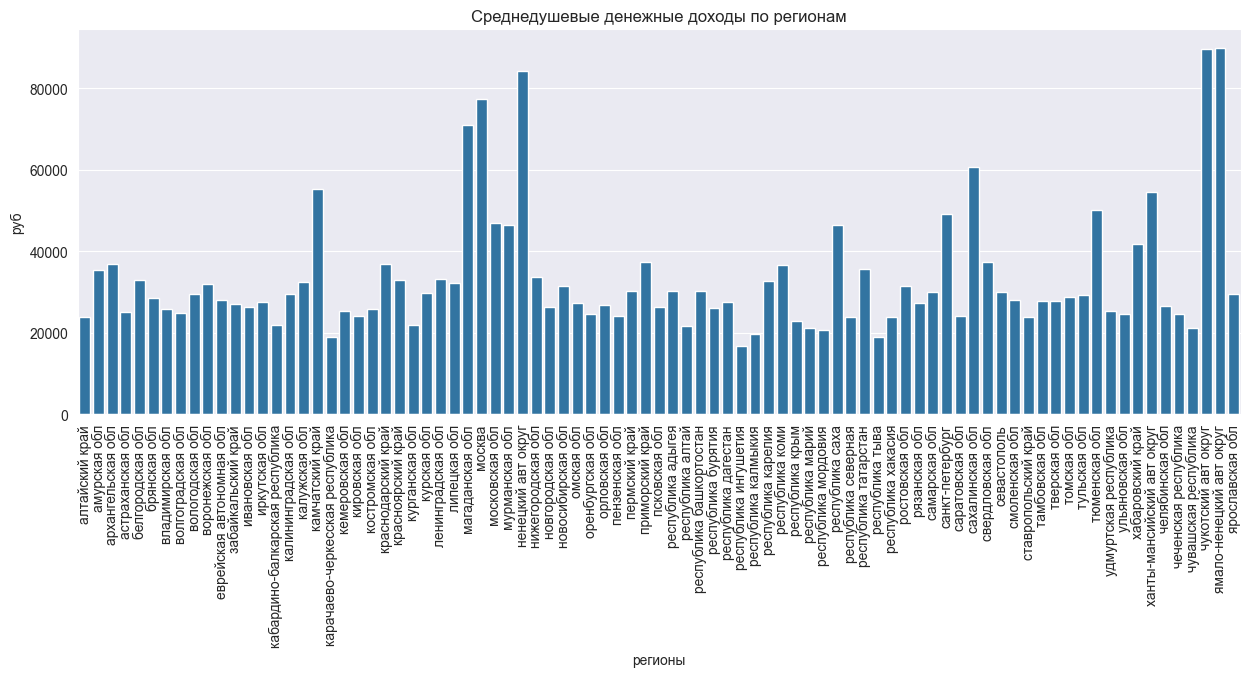

In [148]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = 'per_capita_cash_income'

)
ax.set(xlabel='регионы', ylabel='руб', title='Среднедушевые денежные доходы по регионам',)
ax.tick_params(axis='x', rotation=90);

In [149]:
data[data[data.columns[0]] == data[data.columns[0]].min()]

,per_capita_cash_income,per_capita_cash_income_real_incomes,formal_wage_paid,formal_wage_paid_real_pay,child_mortality_rural,child_mortality_urban,total,18_30,31_40,41_50,...,"Сбор, обработка и утилизация отходов; обработка вторичного сырья_other","ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ_other",ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ_other,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА_other",ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА_other,"Производство готовых металлических изделий, не включенных в другие группировки_other","Производство прочих транспортных средств, не включенных в другие группировки_other",Промышленное производство (промышленность)_other,retail_turnover_per_capita_other,welfare_expense_share_other
region,,,,,,,,,,,,,,,,,,,,,
республика ингушетия,16877.0,99.7,29648.0,104.3,23.0,23.0,58205.0,6904.666667,7225.333333,12846.833333,...,0.0,826476.4,920378.4,384177.0,2146473.6,0.0,0.0,4277505.4,50713.0,32.5


In [150]:
data[data.columns[0]].mean()

np.float64(33265.635294117645)

Среднедушевые денежные доходы распределены крайне неравномерно по регионам. Как регионы с наибольшем среднедушевым доходом можно выделить чукотский, ненецкий и ямало-ненецкий АО. Из крупных регионов первой ожидаемо идет москва.
Минимальный среднедушевой доход можно отметить у республики ингушетия.  
В среднем на человека приходится 33.3 тысячи рублей.

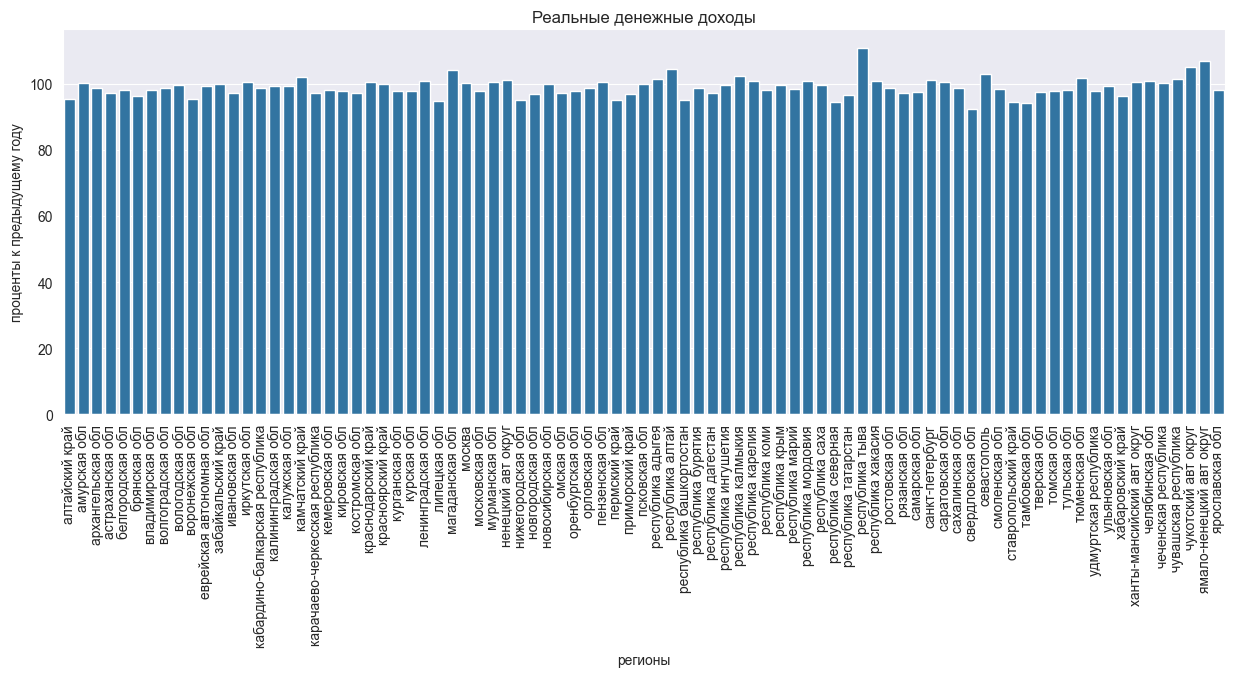

In [151]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[1]]

)
ax.set(xlabel='регионы', ylabel='проценты к предыдущему году', title='Реальные денежные доходы',)
ax.tick_params(axis='x', rotation=90);

In [152]:
data[data[data.columns[1]] == data[data.columns[1]].min()]

,per_capita_cash_income,per_capita_cash_income_real_incomes,formal_wage_paid,formal_wage_paid_real_pay,child_mortality_rural,child_mortality_urban,total,18_30,31_40,41_50,...,"Сбор, обработка и утилизация отходов; обработка вторичного сырья_other","ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ_other",ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ_other,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА_other",ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА_other,"Производство готовых металлических изделий, не включенных в другие группировки_other","Производство прочих транспортных средств, не включенных в другие группировки_other",Промышленное производство (промышленность)_other,retail_turnover_per_capita_other,welfare_expense_share_other
region,,,,,,,,,,,,,,,,,,,,,
свердловская обл,37374.0,92.5,43256.0,102.1,38.0,38.0,270052.25,12913.25,22738.166667,27707.666667,...,0.0,77608009.86,92526767.4,245175701.1,2.072197e+09,0.0,0.0,2.487507e+09,259875.0,23.5


In [153]:
data[data.columns[1]].mean()

np.float64(98.9729411764706)

Наибольший рост реальных денежных доходов наблюдается в республике Тыва. Наименьший (-7.5%) наблюдается в свердловской области. Уровень дохода упал к предыдущему году на 1%.

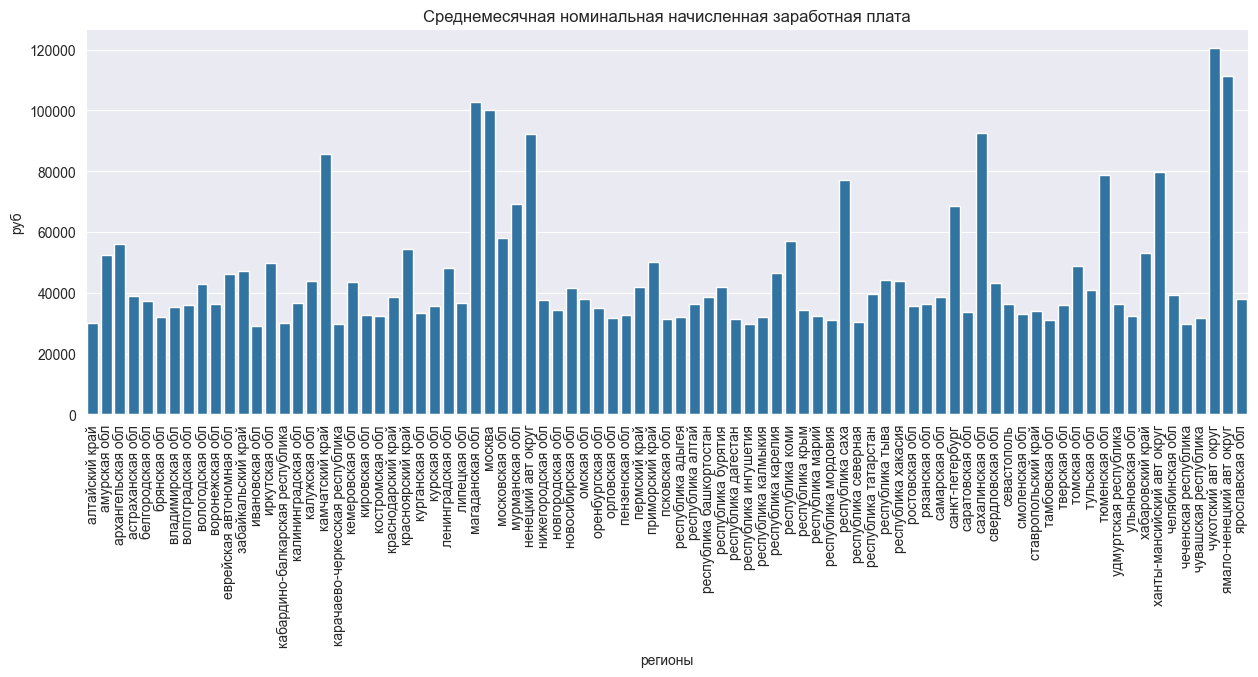

In [154]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[2]]

)
ax.set(xlabel='регионы', ylabel='руб', title='Среднемесячная номинальная начисленная заработная плата',)
ax.tick_params(axis='x', rotation=90);

In [155]:
data[data[data.columns[2]] == data[data.columns[2]].min()]

,per_capita_cash_income,per_capita_cash_income_real_incomes,formal_wage_paid,formal_wage_paid_real_pay,child_mortality_rural,child_mortality_urban,total,18_30,31_40,41_50,...,"Сбор, обработка и утилизация отходов; обработка вторичного сырья_other","ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ_other",ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ_other,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА_other",ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА_other,"Производство готовых металлических изделий, не включенных в другие группировки_other","Производство прочих транспортных средств, не включенных в другие группировки_other",Промышленное производство (промышленность)_other,retail_turnover_per_capita_other,welfare_expense_share_other
region,,,,,,,,,,,,,,,,,,,,,
ивановская обл,26277.0,97.2,29083.0,101.6,3.0,3.0,76565.083333,2594.166667,4588.333333,6419.5,...,0.0,6394404.2,1170505.2,28174991.4,184046210.8,0.0,0.0,219786111.6,180314.0,25.1


In [156]:
data[data.columns[2]].mean()

np.float64(45716.7294117647)

По среднемесячнаой номинальной начисленной заработной плате как и по доходам лидируют чукотский автономный округ и ямало-ненецкий автономный округ. Абсолютный минимум показывает ивановская область. Ненецкий АО по зарплатам отстает от магаданской области и Москвы. Среднемесячная начисленная заработная плата составляет 45.7 тысяч рублей.

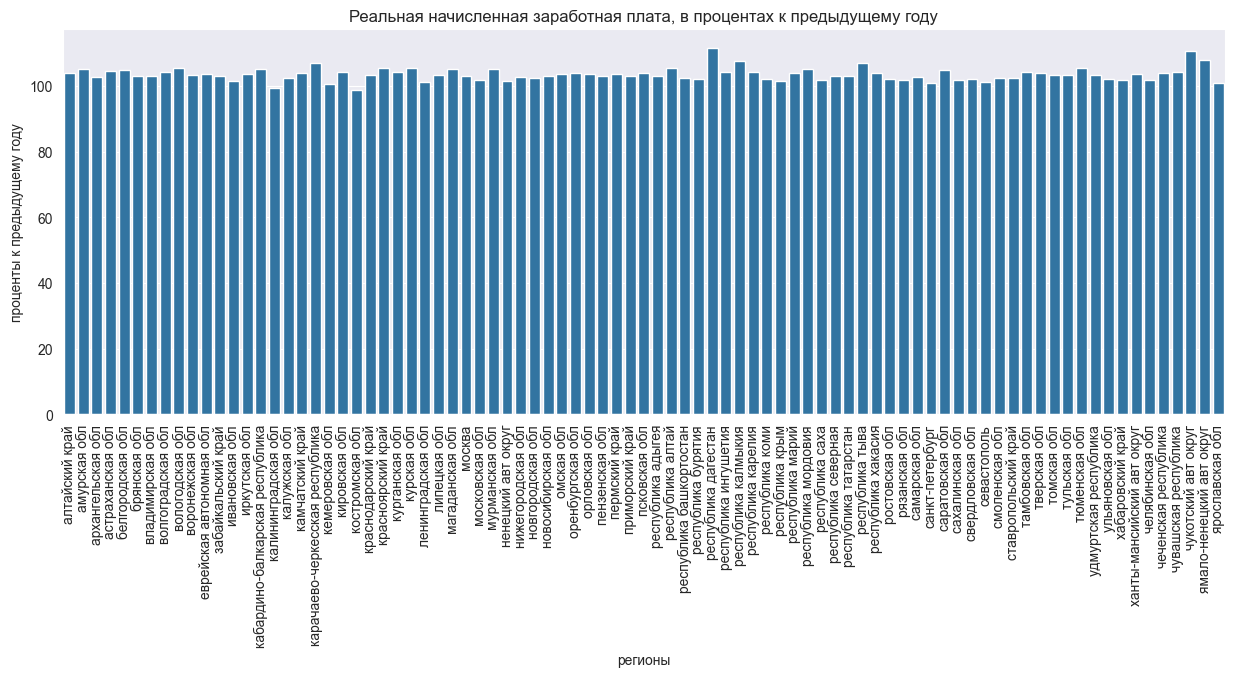

In [157]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[3]]

)
ax.set(xlabel='регионы', ylabel='проценты к предыдущему году', title='Реальная начисленная заработная плата, в процентах к предыдущему году',)
ax.tick_params(axis='x', rotation=90);

In [158]:
data[data[data.columns[3]] == data[data.columns[3]].min()]

,per_capita_cash_income,per_capita_cash_income_real_incomes,formal_wage_paid,formal_wage_paid_real_pay,child_mortality_rural,child_mortality_urban,total,18_30,31_40,41_50,...,"Сбор, обработка и утилизация отходов; обработка вторичного сырья_other","ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ_other",ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ_other,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА_other",ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА_other,"Производство готовых металлических изделий, не включенных в другие группировки_other","Производство прочих транспортных средств, не включенных в другие группировки_other",Промышленное производство (промышленность)_other,retail_turnover_per_capita_other,welfare_expense_share_other
region,,,,,,,,,,,,,,,,,,,,,
костромская обл,25780.0,97.3,32220.0,98.6,13.0,13.0,57721.166667,1916.75,3722.75,4678.916667,...,0.0,3817116.6,1151136.2,32142719.0,137460634.8,0.0,0.0,174571606.6,179587.0,22.5


In [159]:
data[data.columns[3]].mean()

np.float64(103.51529411764704)

Максимальный рост зарплат наблюдается в Дагестане, минимальные же значения (-2.7%) показывает костромская область. В среднем по регионам рост составил 3.5%. 

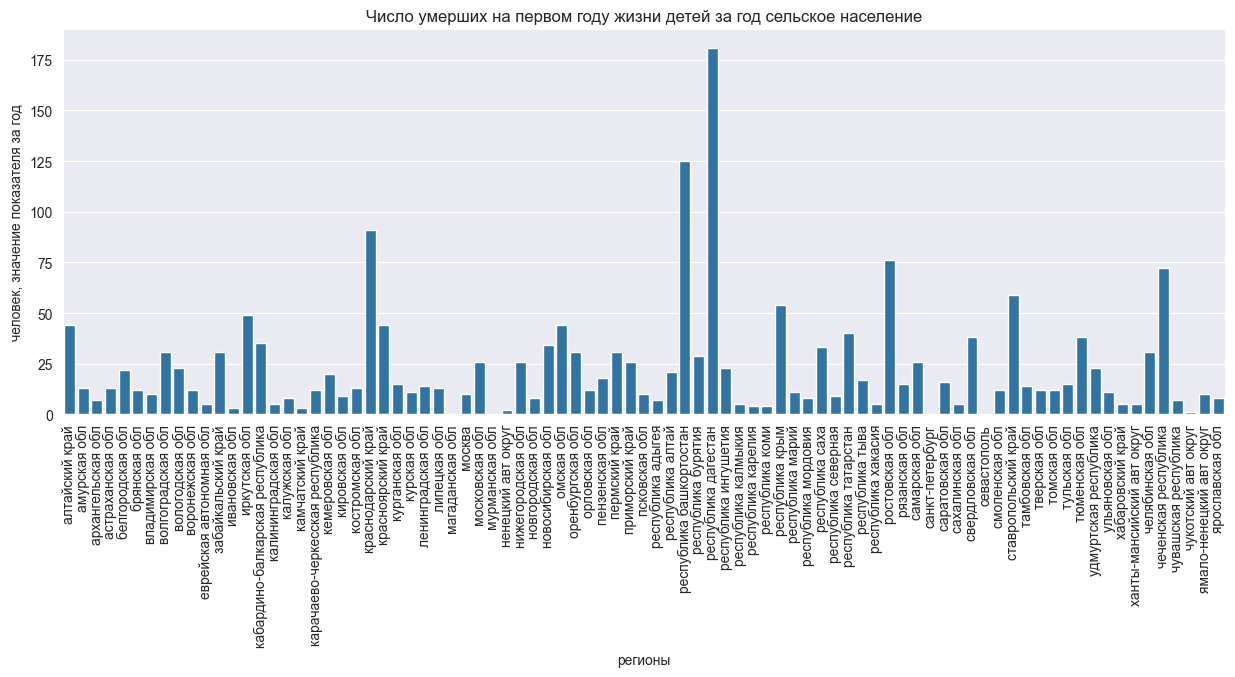

In [160]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[4]]

)
ax.set(xlabel='регионы', ylabel='человек, значение показателя за год', title='Число умерших на первом году жизни детей за год сельское население',)
ax.tick_params(axis='x', rotation=90);

В получившемся датасете нет данных по некоторым регионам (например магаданская область, ненецкий автономный округ). Абсолютный максимум по смертности показывает республика Дагестан.  
Так же следует проверить данные на наличие пропусков и заполнить их нулями.

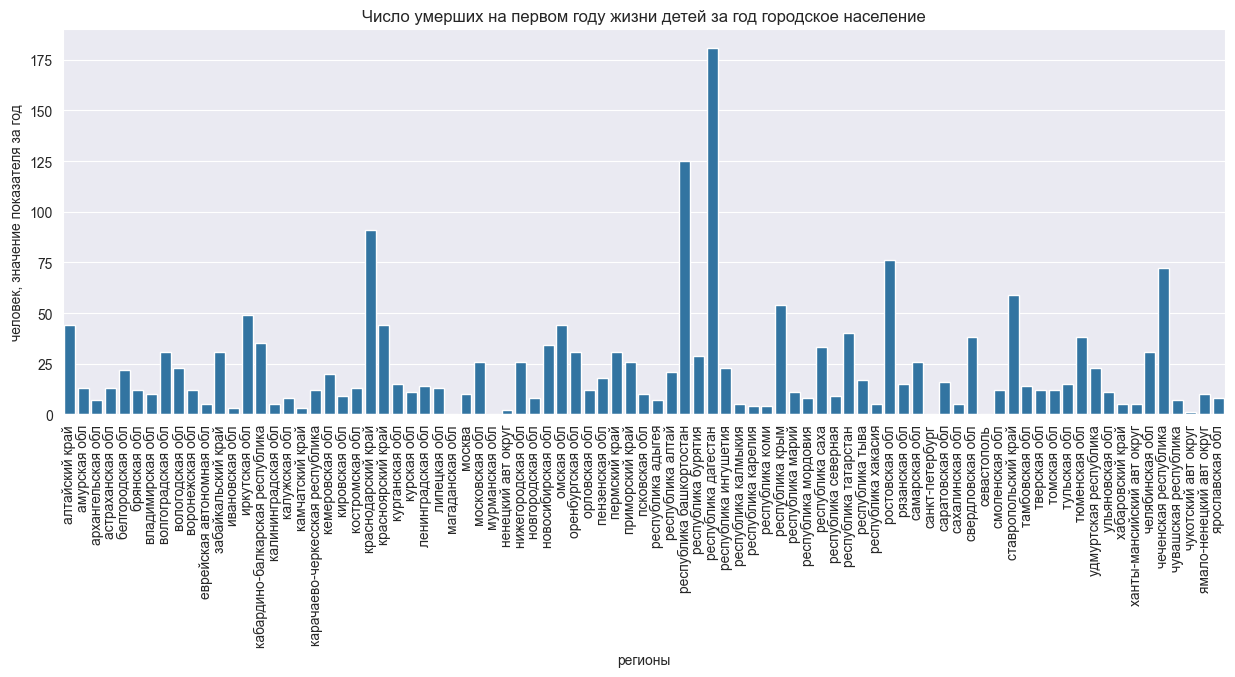

In [161]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[5]]

)
ax.set(xlabel='регионы', ylabel='человек, значение показателя за год', title='Число умерших на первом году жизни детей за год городское население',)
ax.tick_params(axis='x', rotation=90);

Регионом с наибольшей детской смертностью снова оказался Дагестан.

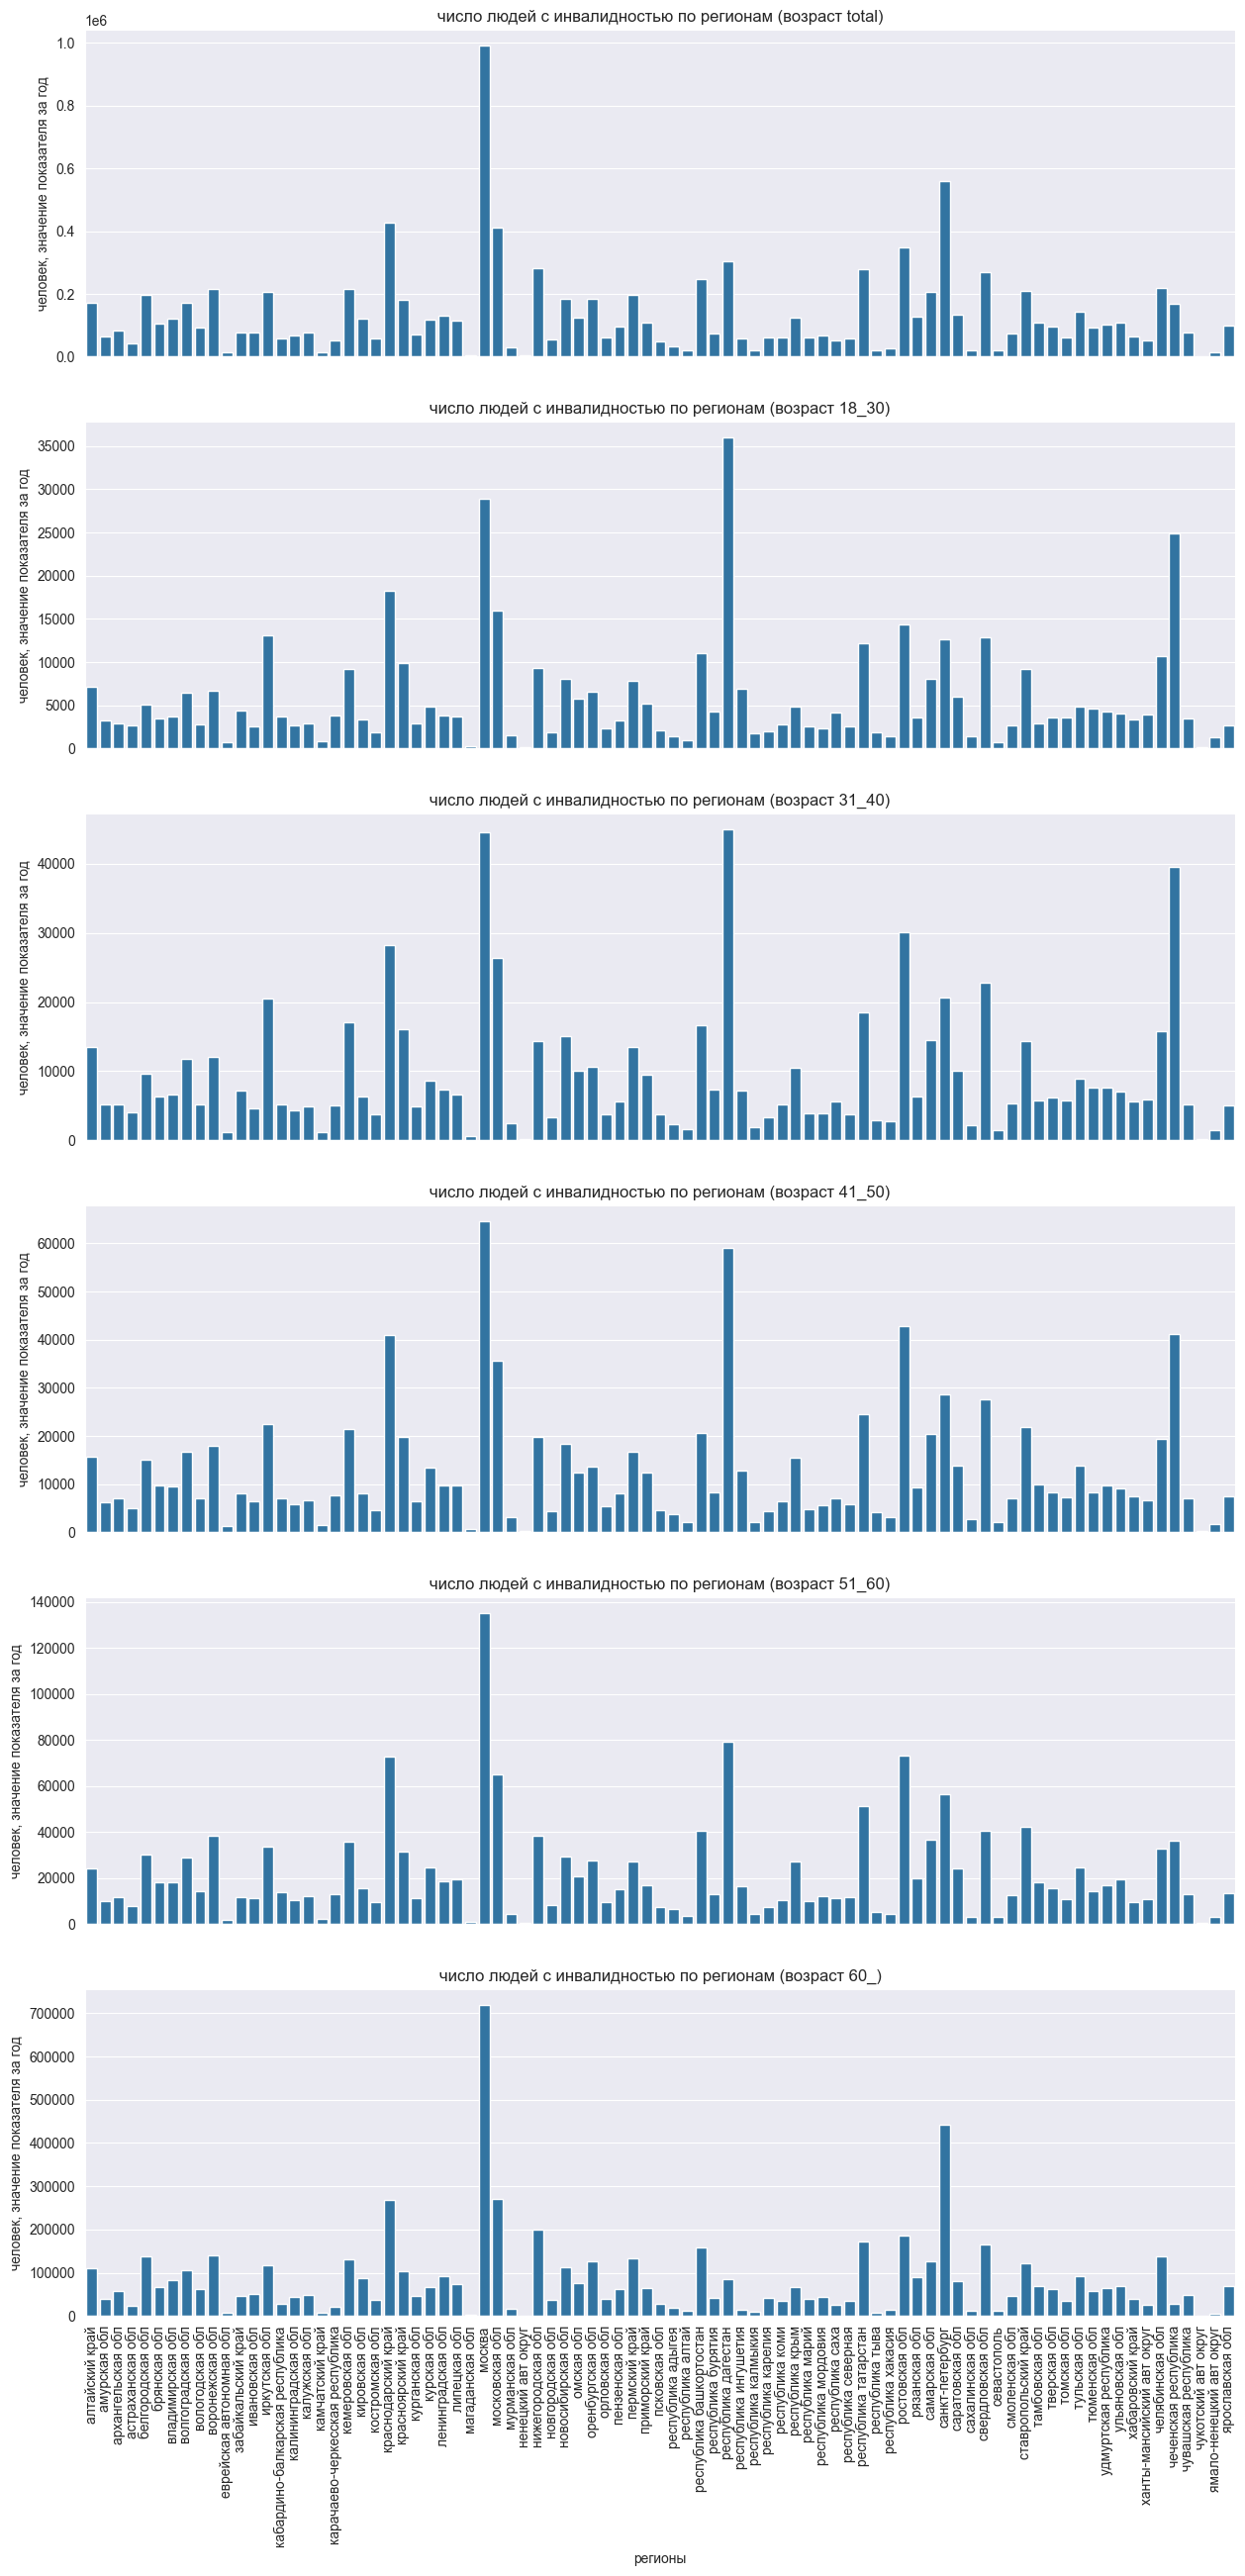

In [162]:
fig, axes = plt.subplots(6, figsize=(15, 30))

ax_num = 0
for col in data[[data.columns[6], data.columns[7], data.columns[8], data.columns[9], data.columns[10], data.columns[11]]].columns:
    ax = sns.barplot(
            x = data.index,
            y = data[col],
            ax = axes[ax_num]
               )
    ax_num += 1
    ax.set(xlabel='регионы', ylabel='человек, значение показателя за год', title=f'число людей с инвалидностью по регионам (возраст {col})',)
    if ax_num !=6:
        ax.tick_params(axis='x', rotation=90, labelcolor='white');
ax.tick_params(axis='x', rotation=90);

Почти по всем возрастам наибольшее количество инвалидов проживает в Москве и Санкт-Петербурге. Возможно, так как параметр не относительный, сказивается численность населения региона.  Интересно посмотреть есть ли корреляция между признаками.

In [163]:
fig = px.imshow(data[[data.columns[6], data.columns[7], data.columns[8], data.columns[9], data.columns[10], data.columns[11]]].corr(numeric_only=True), 
                text_auto=True, aspect="auto",
                # width=40,
                # height=100
                )
fig.update_layout(width=1500, height=1500)

fig.show()

Наблюдается сильная корреляция общего числа людей с инвалидностью и инвалидов возрастом более 60 лет. Отсюда можем предположить, что наибольшеее количество инвалидов наюлюдается в категории более 60 лет. Между сотальными возрасатми так же присутствует корееляция. Возможно количество инвалидоа в категориях 18-30, 31-40, 41-50, 51-60 примерно равно.

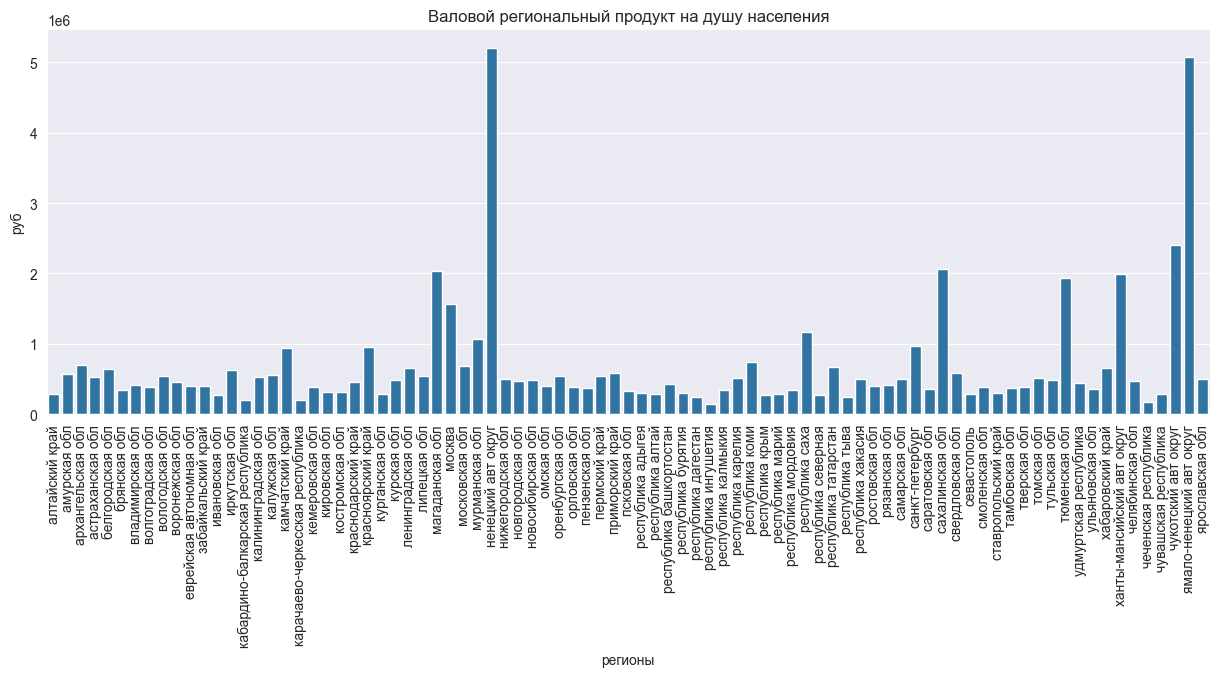

In [164]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[12]]

)
ax.set(xlabel='регионы', ylabel='руб', title='Валовой региональный продукт на душу населения',)
ax.tick_params(axis='x', rotation=90);

Наблюдаем наибольший валовый продукт в Ямало-ненецком и ненецком автономных округах. Наименьший валовый продукт можно наблюдать у республики Ингушетия.

Проверим данные по жилью на пропуски. и при наличии заполним их медианным значением.

In [165]:
data[data.columns[13:21]].isna().sum()

в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность                     1
в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность                          1
Размер жилой площади в расчете на члена домохозяйства                                                             1
Число жилых комнат в расчете на одно домохозяйство                                                                1
из них домохозяйства, собирающиеся улучшить свои жилищные условия                                                 1
из них указавшие: на стесненность проживания                                                                      1
из них указавшие: на плохое или очень плохое состояние жилого помещения                                           1
из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания    1
dtype: int64

In [166]:
for i in range(13, 21):
    data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

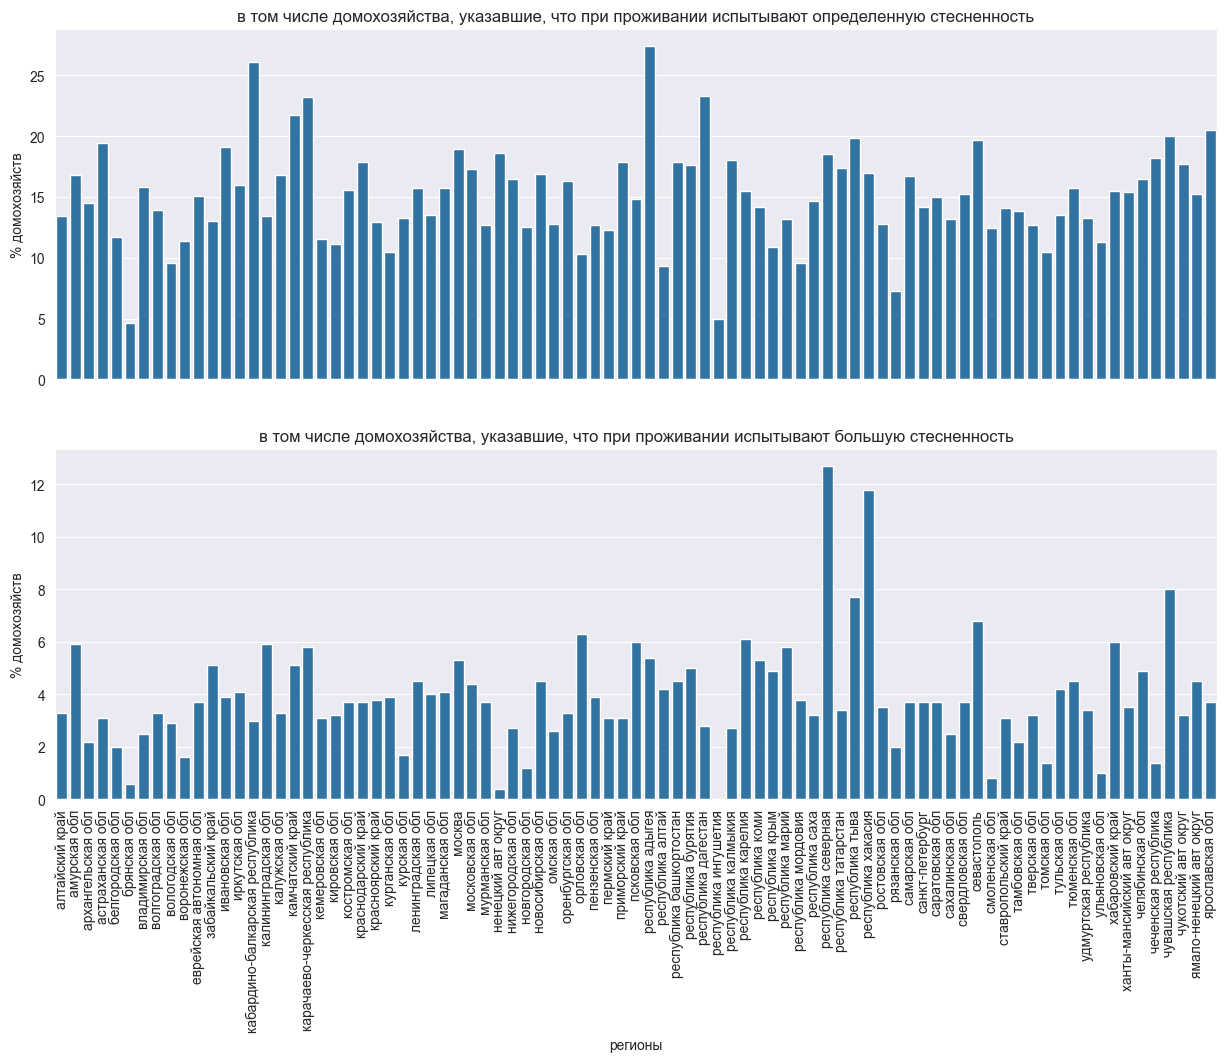

In [167]:
fig, axes = plt.subplots(2, figsize=(15, 10))

ax_num = 0
for col in data[data.columns[13:15]].columns:
    ax = sns.barplot(
            x = data.index,
            y = data[col],
            ax = axes[ax_num]
               )
    ax_num += 1
    ax.set(xlabel='регионы', ylabel='% домохозяйств', title=f'{col}',)
    
    if ax_num !=2:
        ax.tick_params(axis='x', rotation=90, labelcolor='white');
ax.tick_params(axis='x', rotation=90);

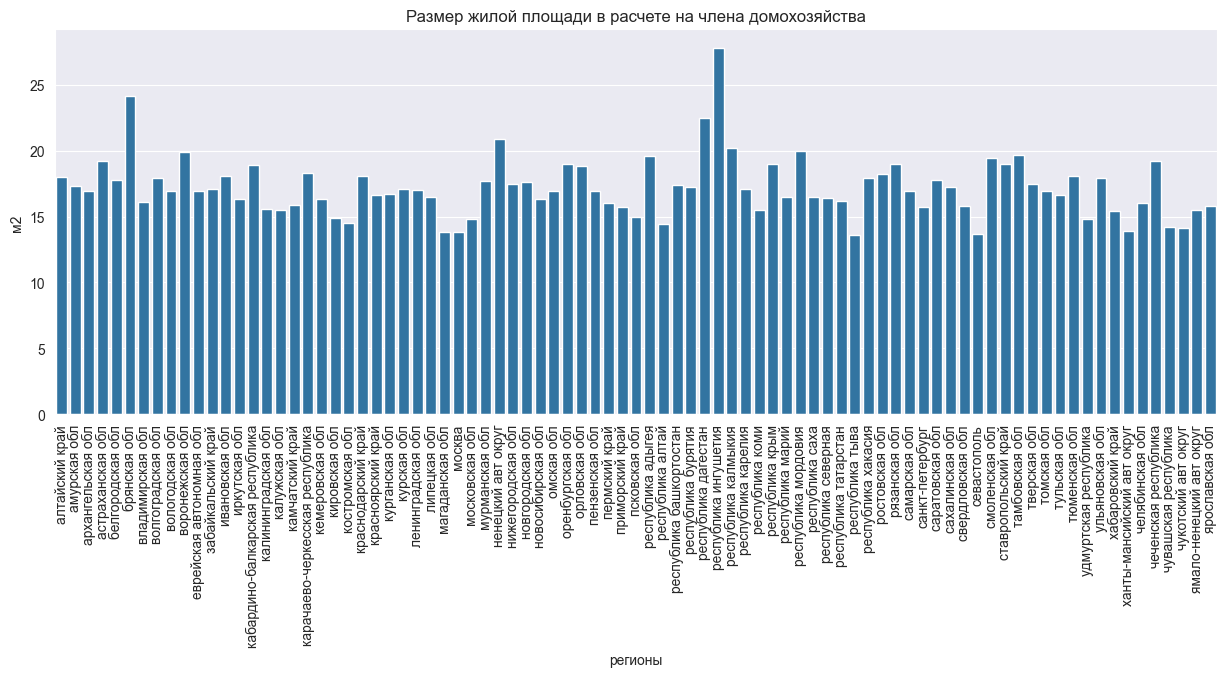

In [168]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[15]]

)
ax.set(xlabel='регионы', ylabel='м2', title=f'{data.columns[15]}',)
ax.tick_params(axis='x', rotation=90);

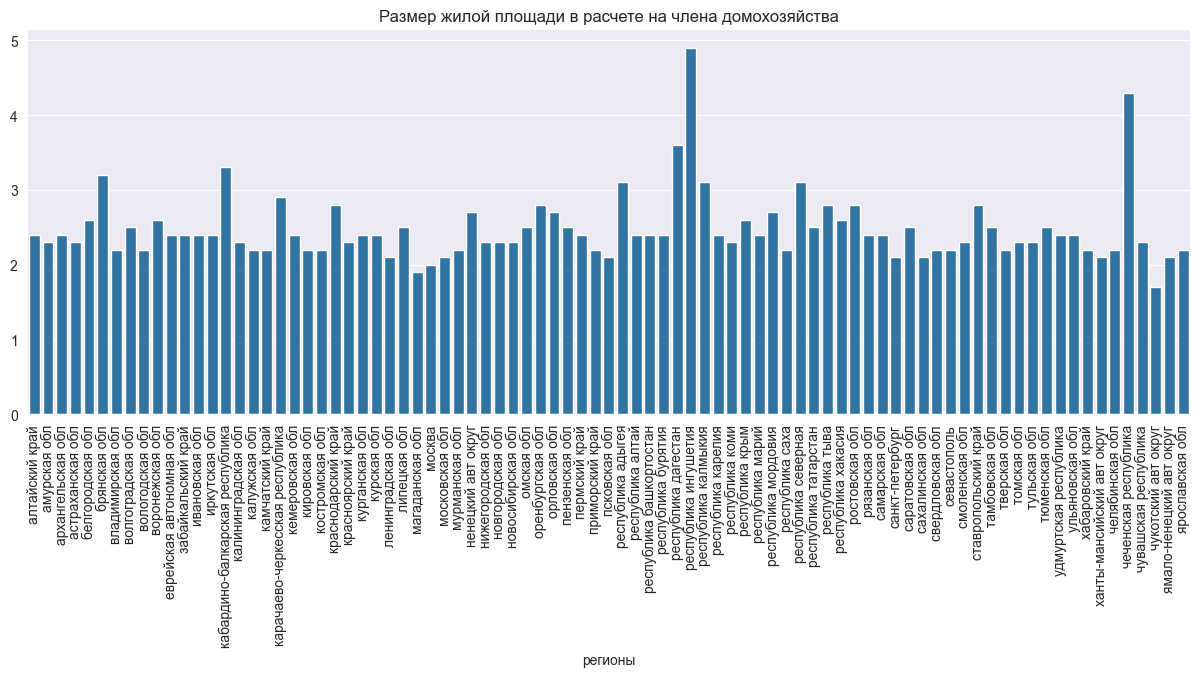

In [169]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[16]]

)
ax.set(xlabel='регионы', ylabel='', title=f'{data.columns[15]}',)
ax.tick_params(axis='x', rotation=90);

По жилищным условиям наилучшее положение у республик Ингушетия и Чечня, а наихудшие у крупных городов (Москва, Санкт-Петербург)

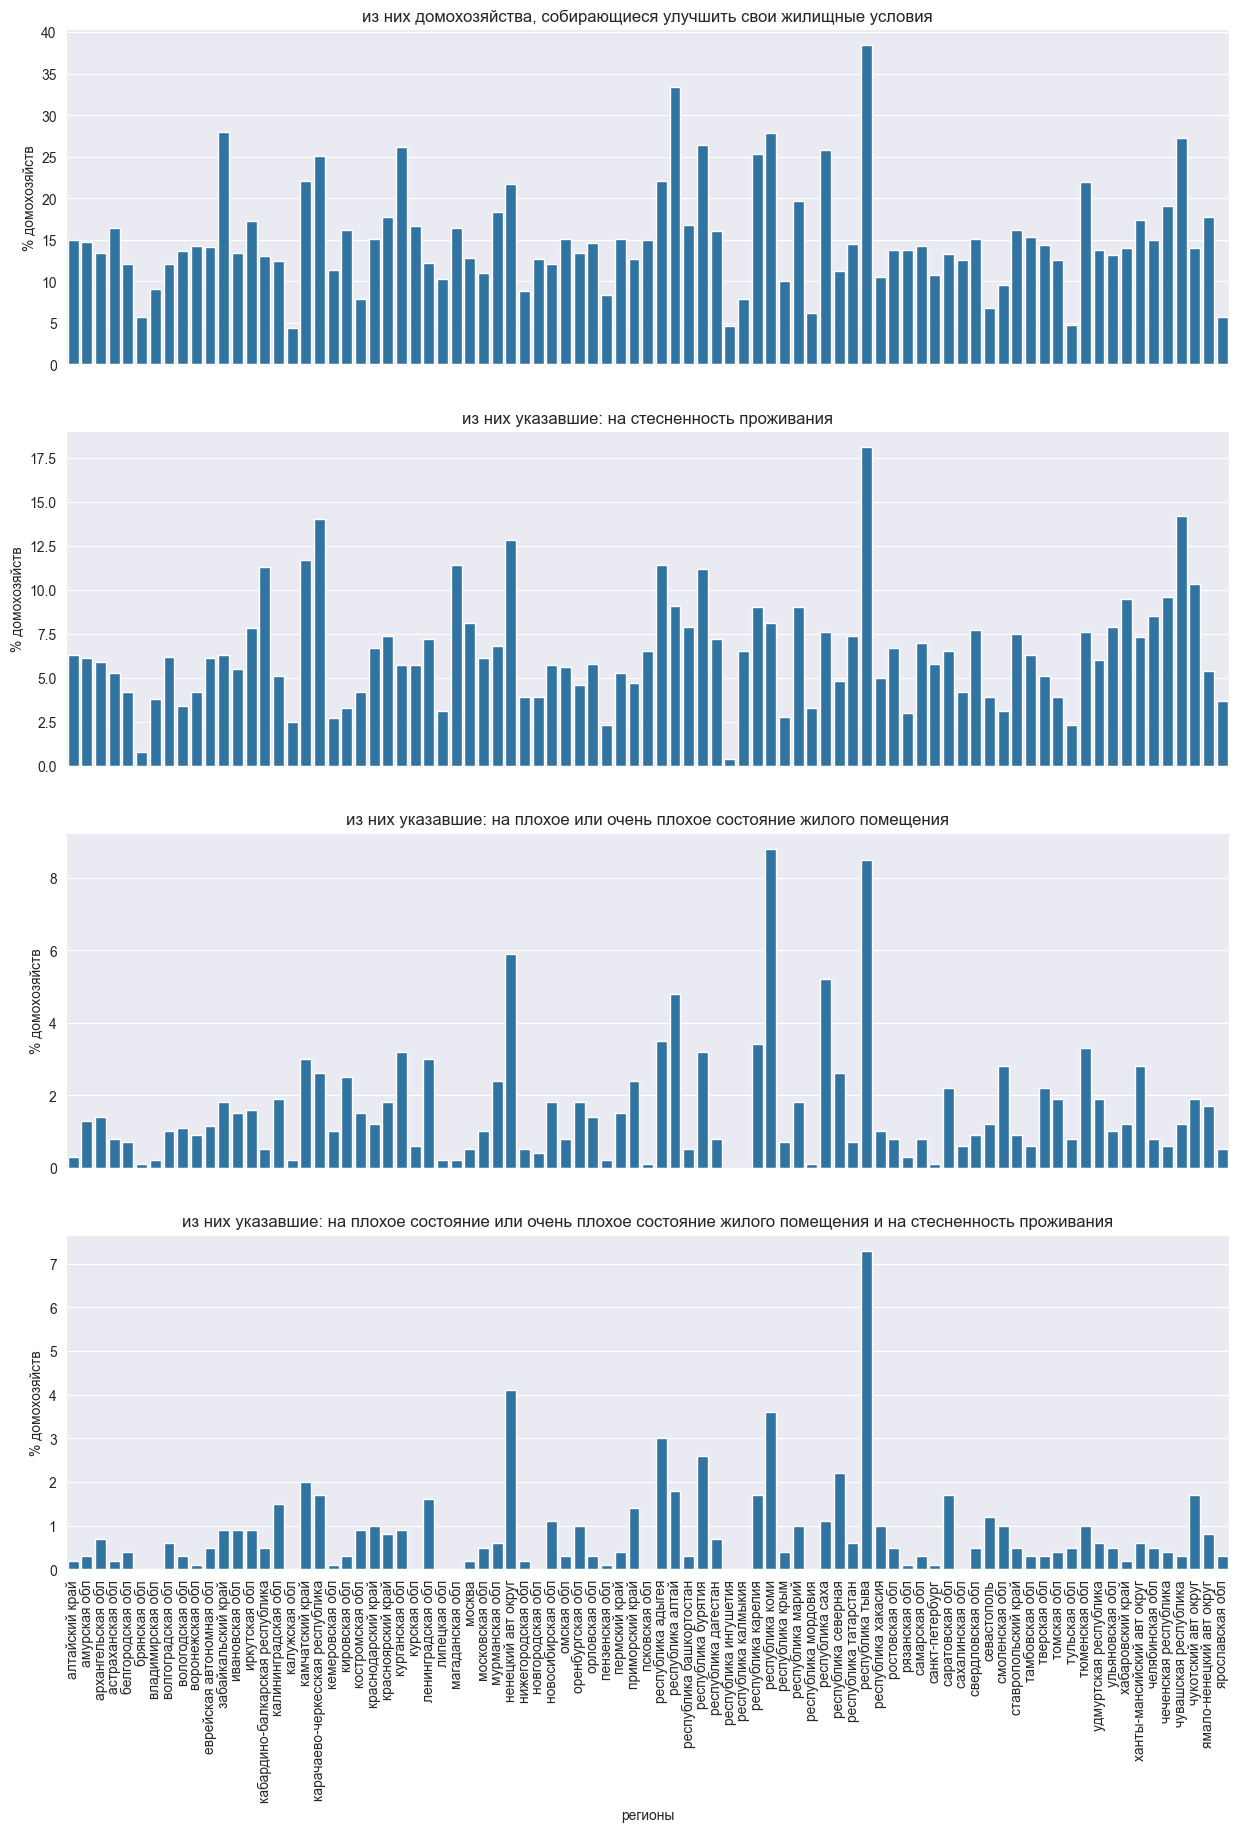

In [170]:
fig, axes = plt.subplots(4, figsize=(15, 20))

ax_num = 0
for col in data[data.columns[17:21]].columns:
    ax = sns.barplot(
            x = data.index,
            y = data[col],
            ax = axes[ax_num]
               )
    ax_num += 1
    ax.set(xlabel='регионы', ylabel='% домохозяйств', title=f'{col}',)
    
    if ax_num !=4:
        ax.tick_params(axis='x', rotation=90, labelcolor='white');
ax.tick_params(axis='x', rotation=90);

А вот жалуются больше всего на условия проживания в республике Тыва и республике Коми. В Москве и Санкт-Петербурге на условия проживания жалуются в меньшей степени.

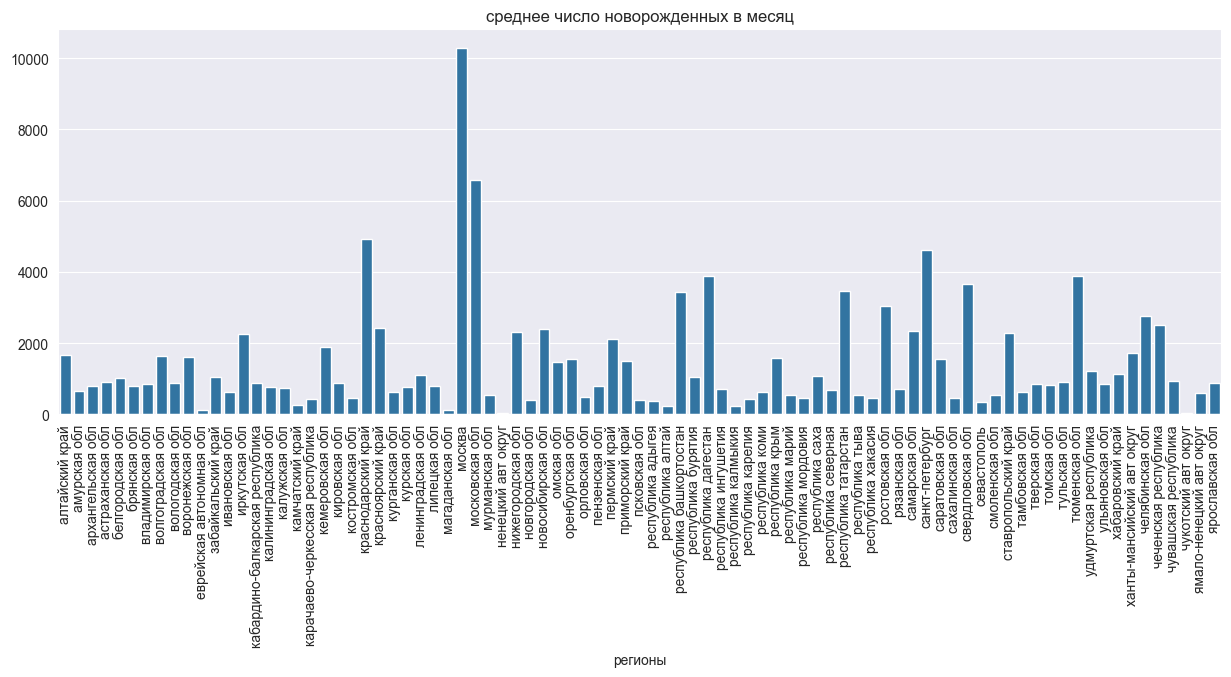

In [171]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data,
    x = data.index,
    y = data[data.columns[21]]

)
ax.set(xlabel='регионы', ylabel='', title='среднее число новорожденных в месяц',)
ax.tick_params(axis='x', rotation=90);

Наибольшее количество новорожденных можно наблюдать в Москве, наименьшее в чукотском автономном округе. Показатели опять же привязаны к плотности населения и у более населенных районов они будут выше.

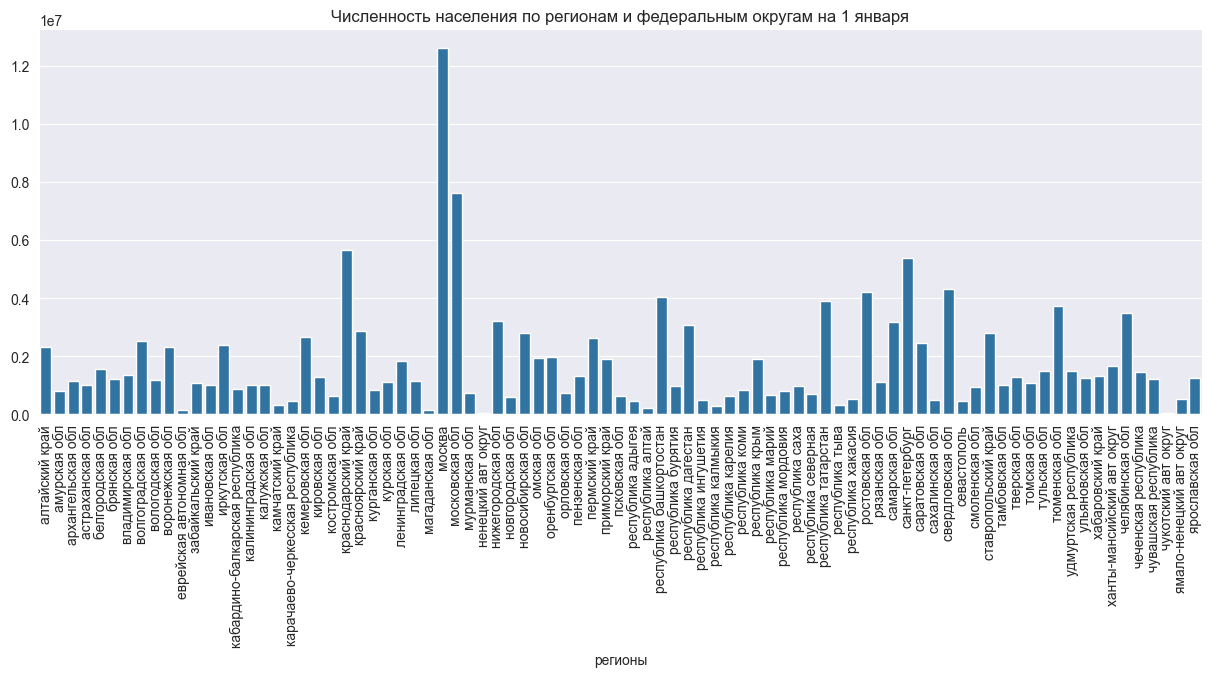

In [172]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[22]]

)
ax.set(xlabel='регионы', ylabel='', title='Численность населения по регионам и федеральным округам на 1 января',)
ax.tick_params(axis='x', rotation=90);

Как бы обьясняя предыдущие графики можно увидеть наибольшее насеение проживает в Москве, наименьшее в Чукотском АО.

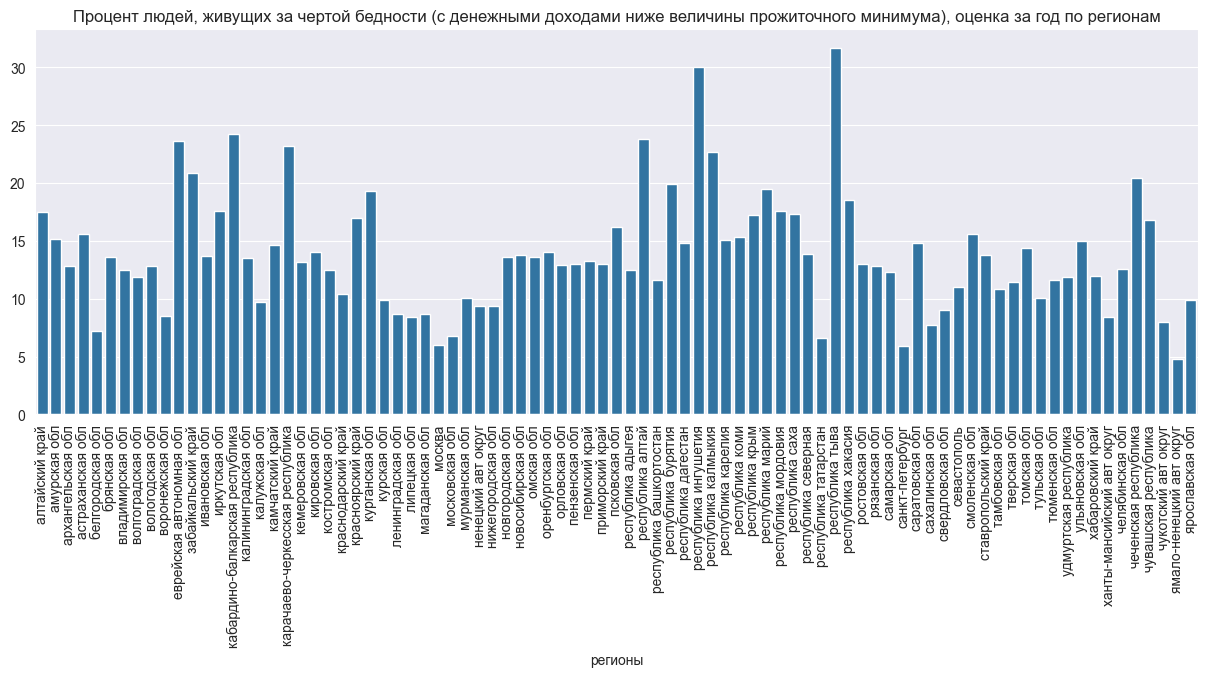

In [173]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[23]]

)
ax.set(xlabel='регионы', ylabel='', title='Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам',)
ax.tick_params(axis='x', rotation=90);

По проценту людей, живущих за чертой бедности, лидирует республика Тыва. За ней с небольшим отрывом республика Ингушения.

In [174]:
data[data.columns[24:27]].isna().sum()

Дети в возрасте до 16 лет                    12
Население старше трудоспособного возраста    12
Население трудоспособного возраста           12
dtype: int64

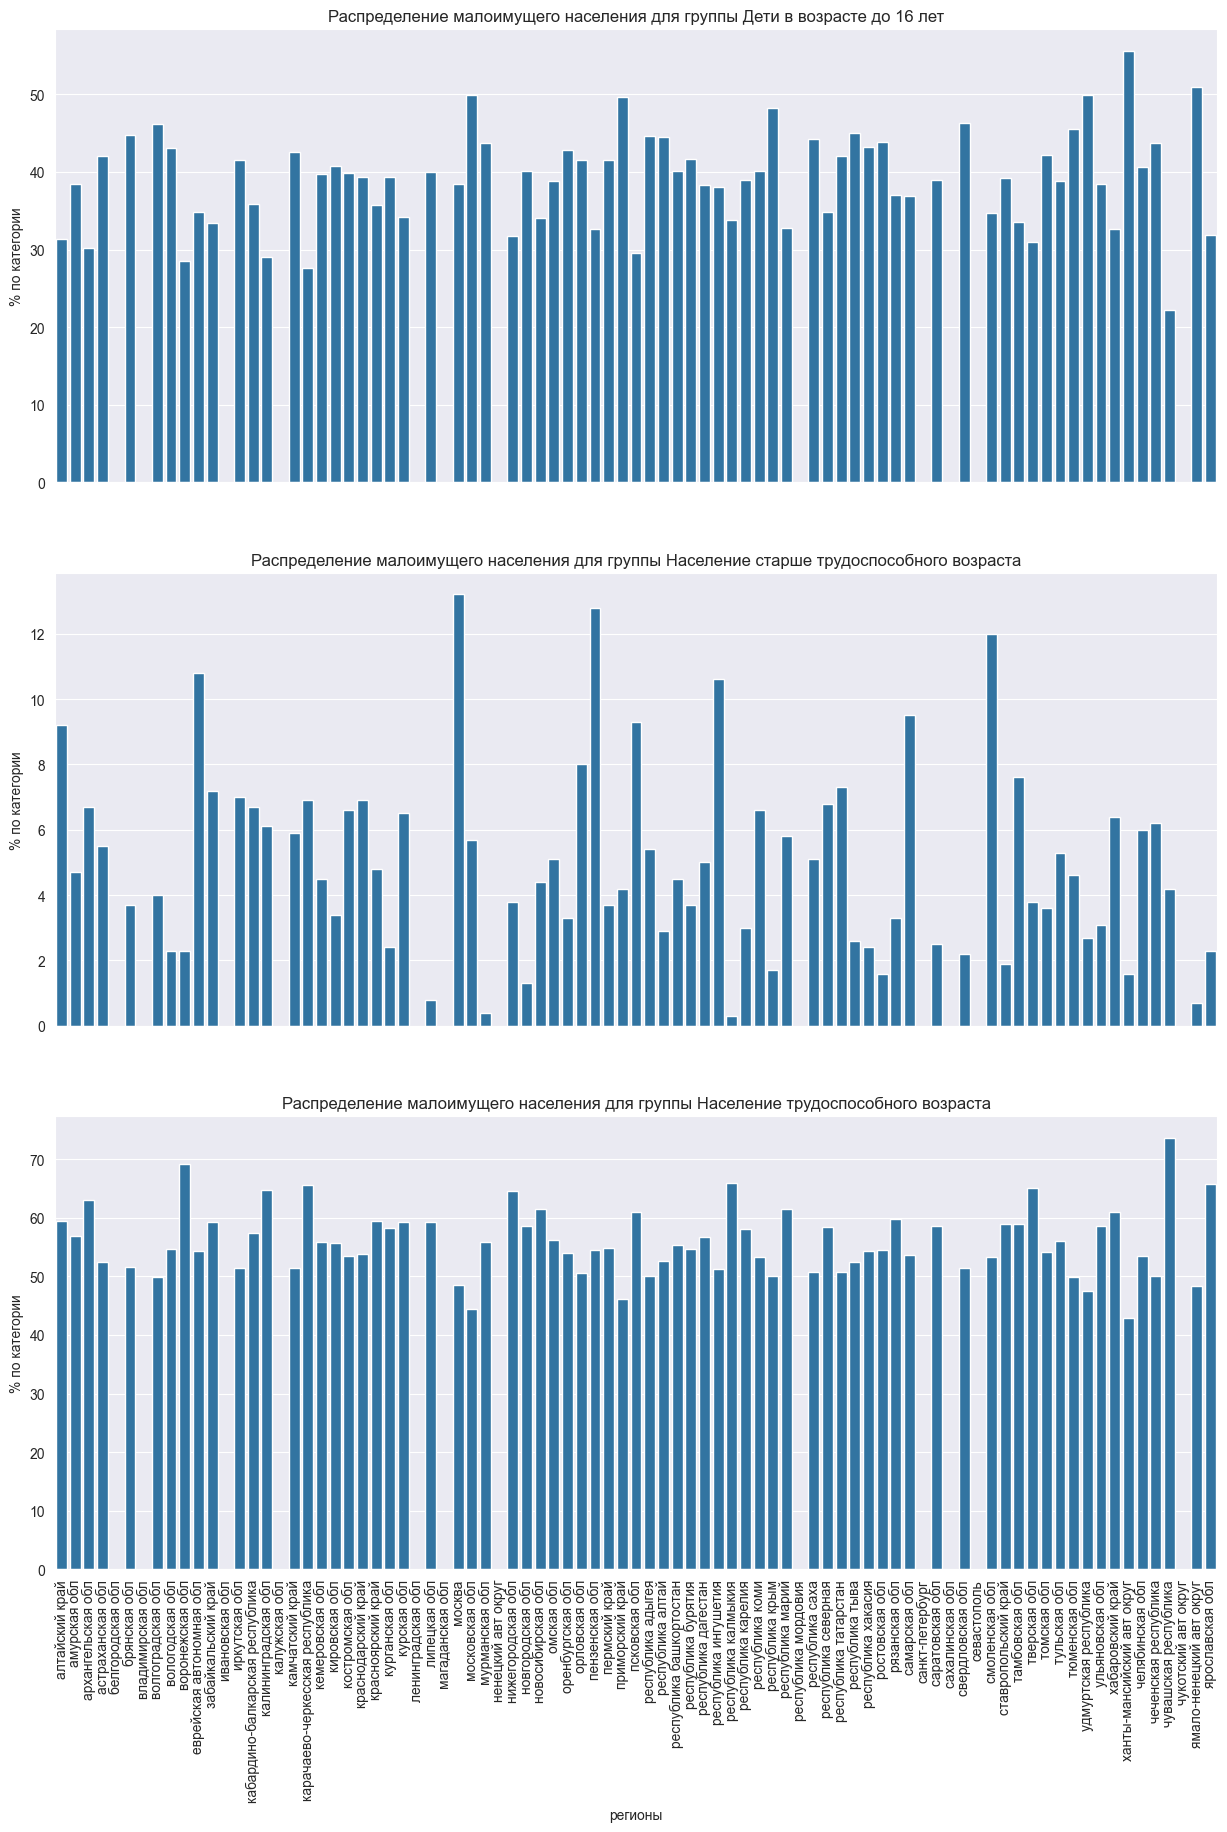

In [175]:
fig, axes = plt.subplots(3, figsize=(15, 20))

ax_num = 0
for col in data[data.columns[24:27]].columns:
    ax = sns.barplot(
            x = data.index,
            y = data[col],
            ax = axes[ax_num]
               )
    ax_num += 1
    ax.set(xlabel='регионы', ylabel='% по категории', title=f'Распределение малоимущего населения для группы {col}',)
    
    if ax_num !=3:
        ax.tick_params(axis='x', rotation=90, labelcolor='white');
ax.tick_params(axis='x', rotation=90);

И хотя данные показательны, но отсутствует информация по 12 регионам. Заполнение пропусков возможно повредит модели. Кроме того данные по бедности у нас уже есть. Предлагаю удалить столбцы с 24 по 26.

In [176]:
data.drop(data.columns[24:27], inplace=True, axis=1)

Предлагаю построить график посуммарному производству в регионе. Так как показатели для всех столбцов учитываются в тысячах рублей, думаю можно сложить столбцы и разделить на число жителей региона.

In [177]:
data['regional_production'] = data[data.columns[24:318]].sum(skipna=True, axis=1)/data[data.columns[22]]

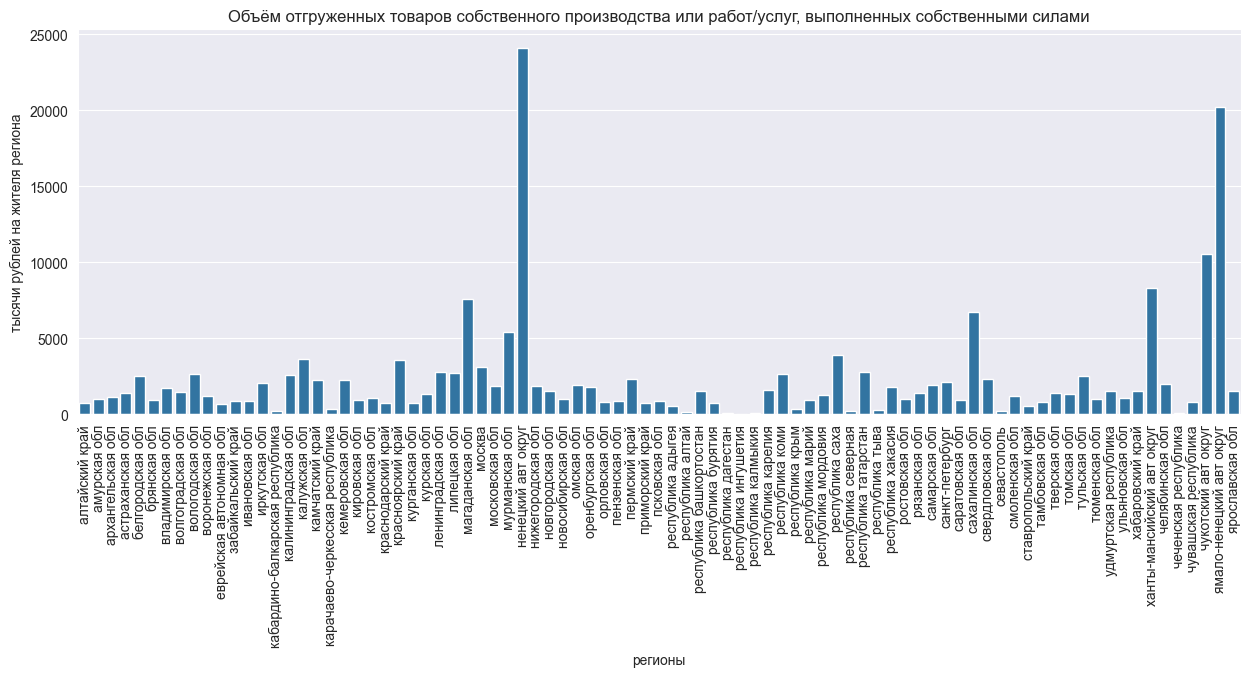

In [178]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data['regional_production']

)
ax.set(xlabel='регионы', ylabel='тысячи рублей на жителя региона', title='Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами',)
ax.tick_params(axis='x', rotation=90);

In [179]:
data[data['regional_production'] == data['regional_production'].min()]

,per_capita_cash_income,per_capita_cash_income_real_incomes,formal_wage_paid,formal_wage_paid_real_pay,child_mortality_rural,child_mortality_urban,total,18_30,31_40,41_50,...,"ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ_other",ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ_other,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА_other",ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА_other,"Производство готовых металлических изделий, не включенных в другие группировки_other","Производство прочих транспортных средств, не включенных в другие группировки_other",Промышленное производство (промышленность)_other,retail_turnover_per_capita_other,welfare_expense_share_other,regional_production
region,,,,,,,,,,,,,,,,,,,,,
республика ингушетия,16877.0,99.7,29648.0,104.3,23.0,23.0,58205.0,6904.666667,7225.333333,12846.833333,...,826476.4,920378.4,384177.0,2146473.6,0.0,0.0,4277505.4,50713.0,32.5,36.083229


In [180]:
data.drop(data.columns[24:318], inplace=True, axis=1)

На основании построенного графика можнозамтить огромный разрыв между Москвой и остальными регионами. По остальным регионам объем так же очень сильно разный. Минимальный объем товаров у республики Ингушетия.

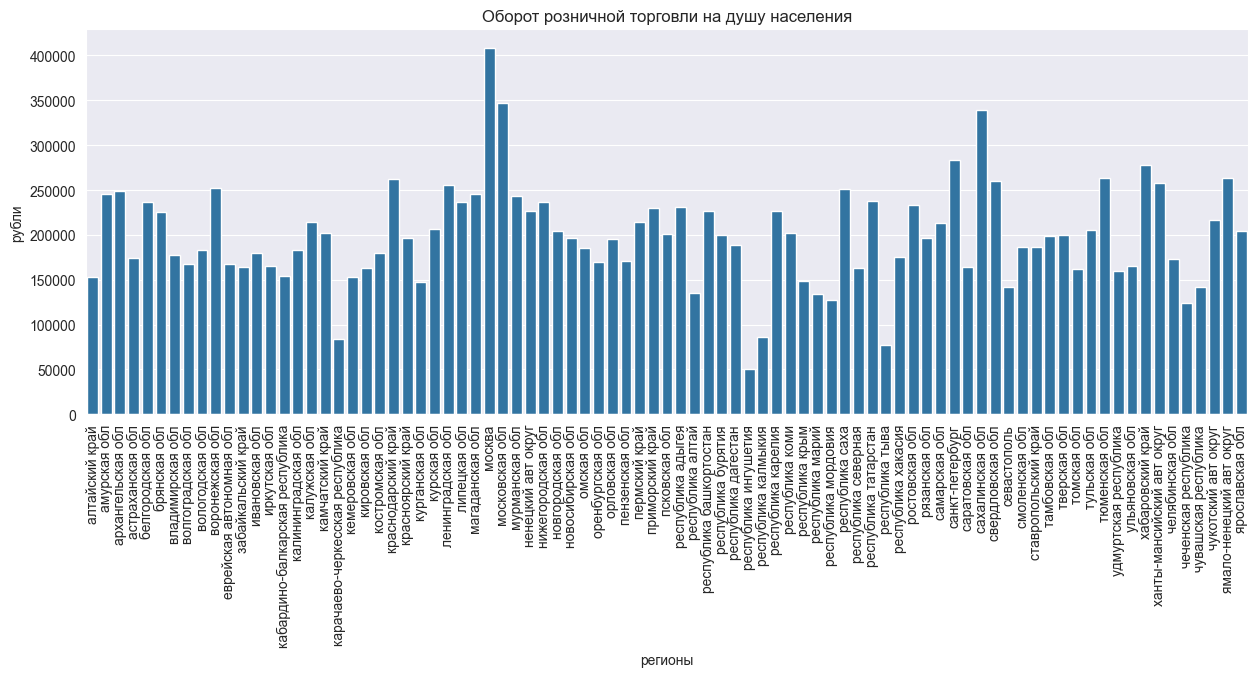

In [181]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[24]]

)
ax.set(xlabel='регионы', ylabel='рубли', title='Оборот розничной торговли на душу населения',)
ax.tick_params(axis='x', rotation=90);

Снова по показателю лидирует Москва, а наименьший оборот имеет Ингушетия. Однако имеет не такой сильный разброс параметров как объем отгруженных товаров.

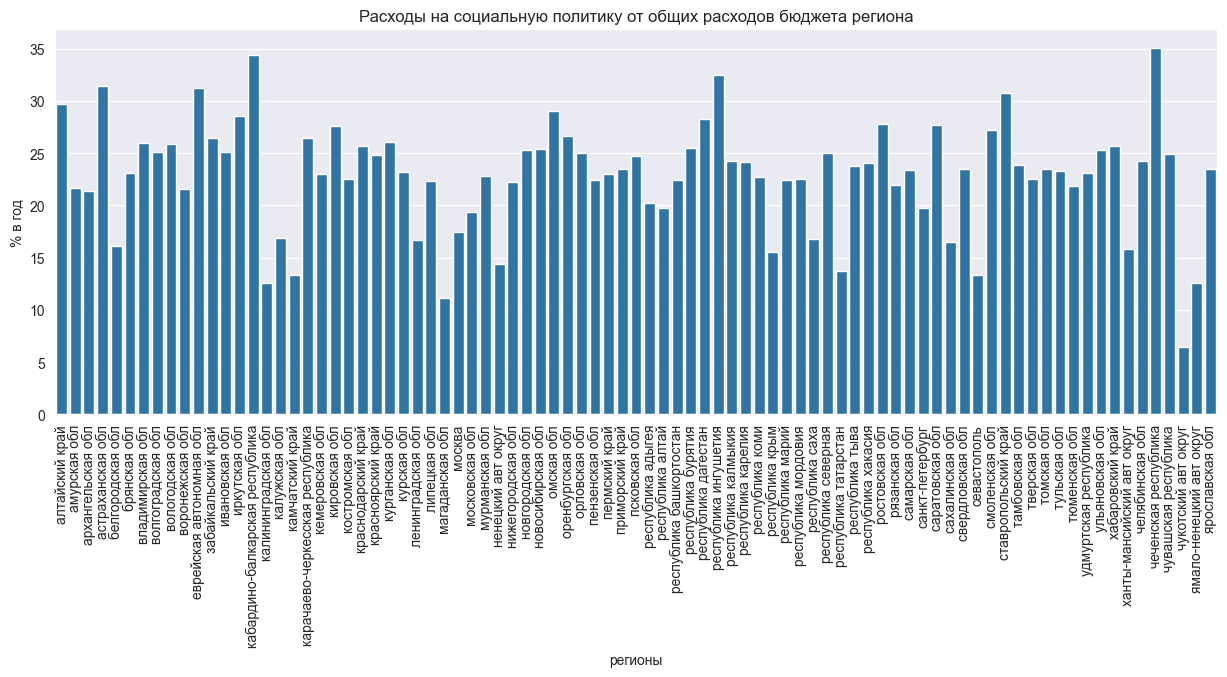

In [182]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data
,
    x = data.index,
    y = data[data.columns[25]]

)
ax.set(xlabel='регионы', ylabel='% в год', title='Расходы на социальную политику от общих расходов бюджета региона',)
ax.tick_params(axis='x', rotation=90);

In [183]:
data[data[data.columns[25]] == data[data.columns[25]].max()]

,per_capita_cash_income,per_capita_cash_income_real_incomes,formal_wage_paid,formal_wage_paid_real_pay,child_mortality_rural,child_mortality_urban,total,18_30,31_40,41_50,...,"из них домохозяйства, собирающиеся улучшить свои жилищные условия",из них указавшие: на стесненность проживания,из них указавшие: на плохое или очень плохое состояние жилого помещения,из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания,middle_newborn,population,poverty_percent,retail_turnover_per_capita_other,welfare_expense_share_other,regional_production
region,,,,,,,,,,,,,,,,,,,,,
чеченская республика,24596.0,100.1,29771.0,104.0,72.0,72.0,169851.333333,24893.25,39461.833333,41117.0,...,19.1,9.6,0.6,0.4,2509.246667,1456951.0,20.4,123955.0,35.1,120.865517


Минимальные расходы на социальную политику наблюдаются в чукотском автономном округе, а максимальнык в чеченской республике. Возможно по этой причине она и опережает ингушетию по остальным показателям.

Здесь необходимо построить таблице корреляции.

In [184]:
fig = px.imshow(data.corr(numeric_only=True), 
                text_auto=True, aspect="auto",
                # width=40,
                # height=100
                )
fig.update_layout(width=1500, height=1500)

fig.show()

Из графика видно корреляцию кол-ва инвалидов и численности населения. Можно предположить что количество инвалидов можно было бы выразить через процент от населения. Большой коэффициент корреляции имеет сумма продукта по регионам и валовый региональный продукт на душу населения. Это и не удивительно, так как в целом это одно и то же.  
Полностью коррелируется детская смертность в городских условиях и детская сметрность в сельской местности.
На кластеризацию коррелирующие коэфициенты влияния оказать не должны, поэтому предлагаю пока оставить датасет без изменений, за исключением удаления из датасета детской смерности по  

In [185]:
data.drop('child_mortality_rural', inplace=True, axis=1)

### 3.2 Дополнительный датасет (преступность)

In [186]:
fig = px.imshow(crime_data.corr(numeric_only=True), 
                text_auto=True, aspect="auto",
                # width=40,
                # height=100
                )
fig.update_layout(width=1500, height=1500)

fig.show()

In [187]:
crime_data

,несовершеннолетними или при их соучастии всего,ранее совершавшими преступления всего,в том числе ранее судимыми всего,группой лиц всего,группой лиц по предварительному сговору всего,организованной группой всего,преступным сообществом (преступной организацией) всего,в состоянии опьянения алкогольного всего,в состоянии опьянения наркотического всего,в состоянии опьянения токсического всего,...,несовершеннолетними или при их соучастии небольшой тяжести,ранее совершавшими преступления небольшой тяжести,в том числе ранее судимыми небольшой тяжести,группой лиц небольшой тяжести,группой лиц по предварительному сговору небольшой тяжести,организованной группой небольшой тяжести,преступным сообществом (преступной организацией) небольшой тяжести,в состоянии опьянения алкогольного небольшой тяжести,в состоянии опьянения наркотического небольшой тяжести,в состоянии опьянения токсического небольшой тяжести
region,,,,,,,,,,,,,,,,,,,,,
алтайский край,887.0,15400.0,7278.0,64.0,901.0,87.0,2.0,9396.0,46.0,0.0,...,265.0,9251.0,4196.0,30.0,28.0,1.0,0.0,6361.0,31.0,0.0
амурская обл,431.0,6001.0,3078.0,52.0,409.0,57.0,0.0,3123.0,108.0,2.0,...,101.0,3113.0,1585.0,24.0,10.0,1.0,0.0,1875.0,75.0,0.0
архангельская обл,551.0,6569.0,3522.0,45.0,967.0,54.0,0.0,4011.0,31.0,4.0,...,138.0,3651.0,1880.0,23.0,38.0,5.0,0.0,2202.0,14.0,1.0
астраханская обл,343.0,5395.0,2622.0,42.0,680.0,80.0,19.0,2534.0,70.0,2.0,...,47.0,3247.0,1378.0,19.0,22.0,0.0,0.0,1890.0,53.0,2.0
белгородская обл,219.0,4599.0,2787.0,15.0,505.0,26.0,129.0,2251.0,49.0,0.0,...,65.0,2851.0,1630.0,4.0,9.0,0.0,0.0,1562.0,38.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
чеченская республика,6.0,894.0,391.0,5.0,31.0,30.0,0.0,153.0,1.0,0.0,...,2.0,502.0,195.0,3.0,0.0,0.0,0.0,140.0,0.0,0.0
чувашская республика,358.0,4786.0,2626.0,16.0,568.0,500.0,239.0,2495.0,175.0,0.0,...,96.0,2798.0,1581.0,9.0,14.0,0.0,0.0,1579.0,33.0,0.0
чукотский авт округ,15.0,322.0,143.0,3.0,11.0,0.0,0.0,282.0,0.0,0.0,...,6.0,180.0,77.0,3.0,1.0,0.0,0.0,165.0,0.0,0.0


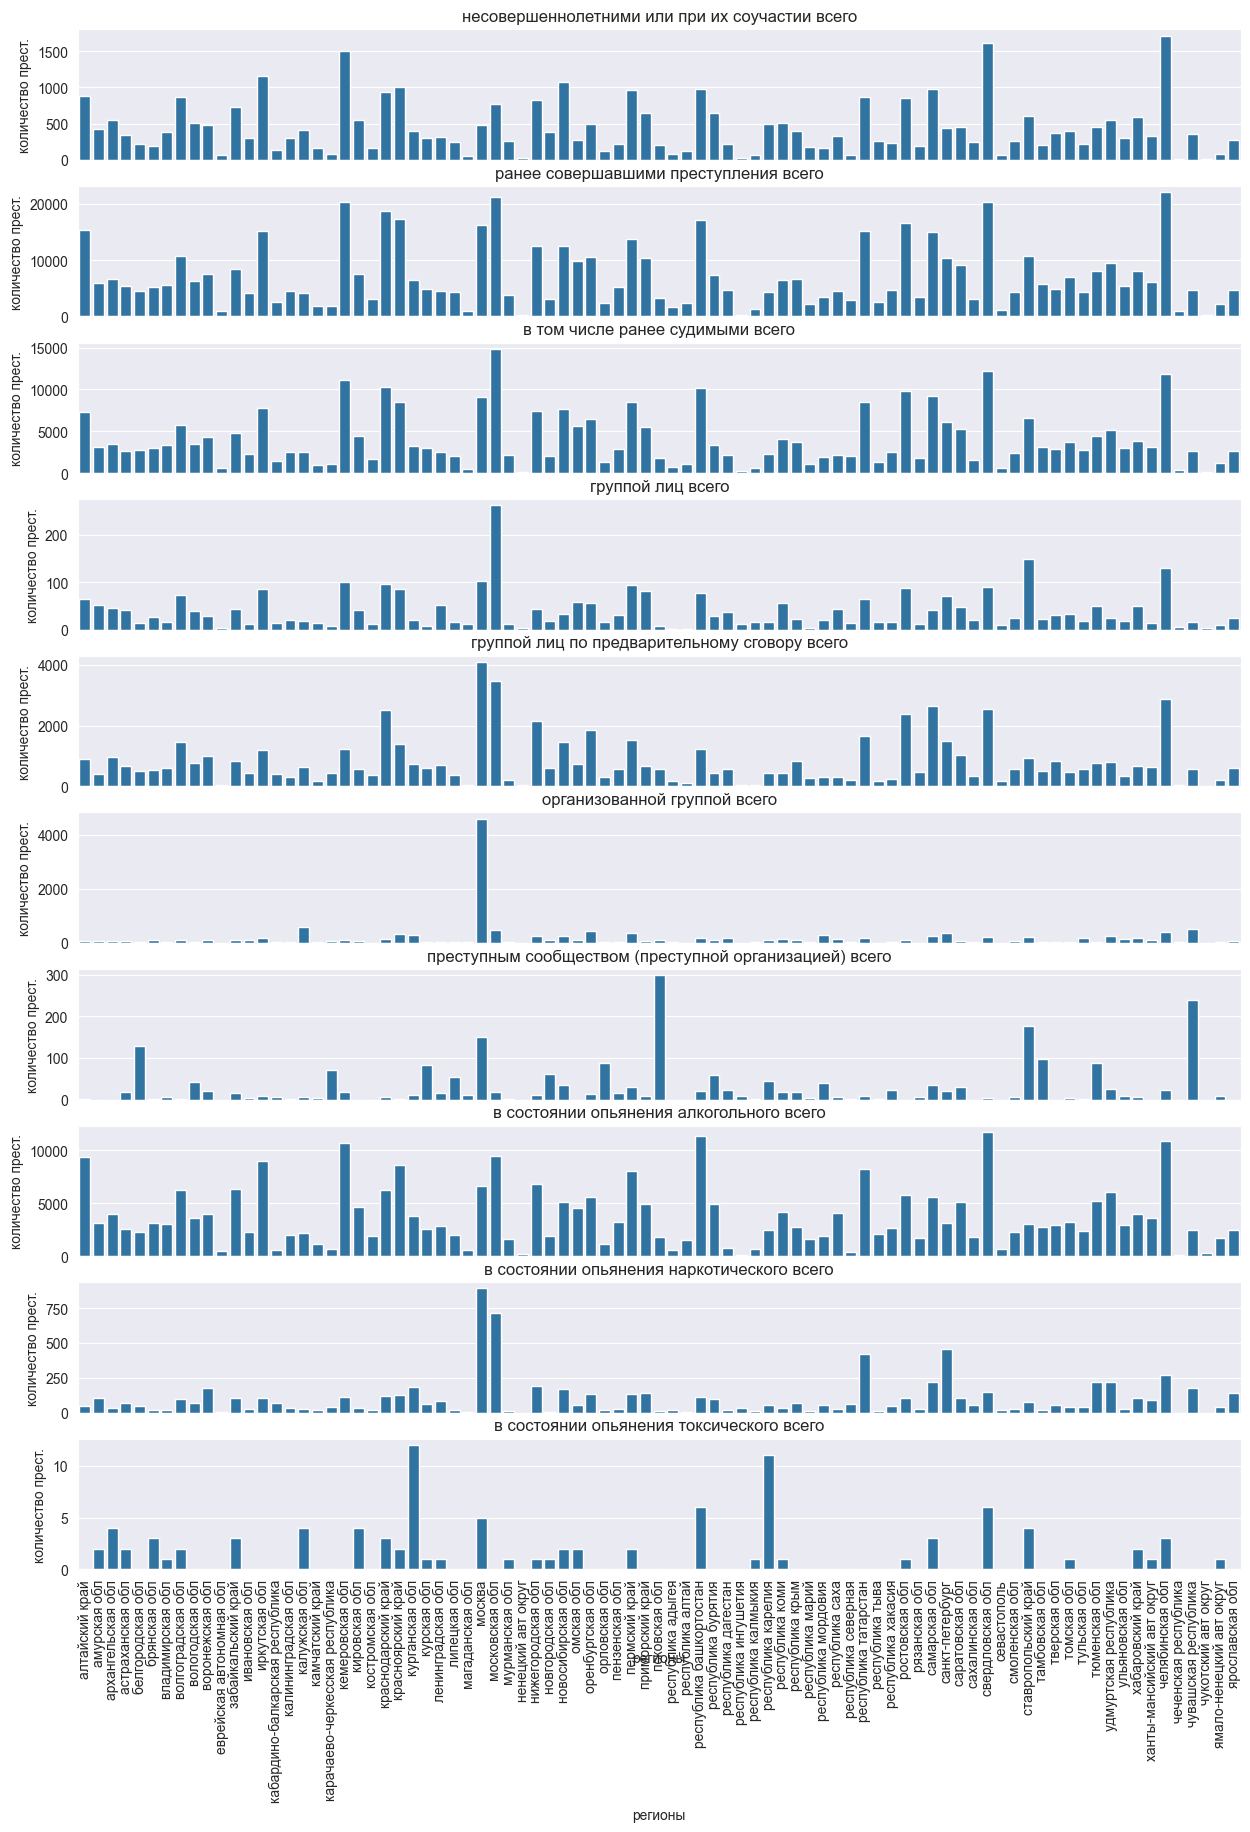

In [195]:
fig, axes = plt.subplots(10, figsize=(15, 20))

ax_num = 0
for col in crime_data[crime_data.columns[0:10]].columns:
    ax = sns.barplot(
            x = crime_data.index,
            y = crime_data[col],
            ax = axes[ax_num]
               )
    ax_num += 1
    ax.set(xlabel='регионы', ylabel='количество прест.', title=f'{col}',)
    
    if ax_num !=10:
        ax.tick_params(axis='x', rotation=90, labelcolor='white');
ax.tick_params(axis='x', rotation=90);

## 4. Построение модели

Для начала попробуем визуально выявить количествокластеров

In [ ]:
data_cleared = data.fillna(0)

In [ ]:
for el in data.isna().sum().index: 
    if data.isna().sum()[el] != 0:
        print(el)

In [ ]:
pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()), ('rf', sklearn.decomposition.PCA(n_components=2))])
data_processed = pipe.fit_transform(data_cleared)
print(f'Первая главная компонента объясняет {round(pipe[1].explained_variance_ratio_[0], 2)}% дисперсии')

Первая главная компонента объясняет 0.32% дисперсии


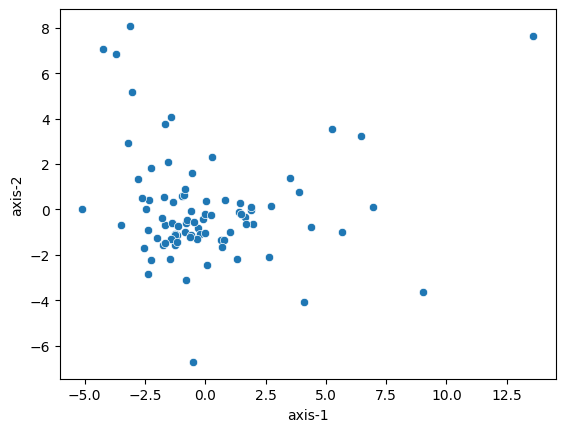

In [ ]:
data_processed = pd.DataFrame(data_processed, columns=['axis-1', 'axis-2'])
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2');

Предварительно четких кластеров на графике не видно.

In [ ]:
siluete_score = []

for i in range(2, 11):
    km = sklearn.cluster.KMeans(n_clusters=i, random_state=42)
    y = km.fit(data_cleared)
    siluete_score.append(sklearn.metrics.silhouette_score(data_processed, km.labels_, metric='euclidean'))

print(f'Максимальное значение коэффициента силуэта - {round(max(siluete_score), 2)}')

Максимальное значение коэффициента силуэта - 0.47


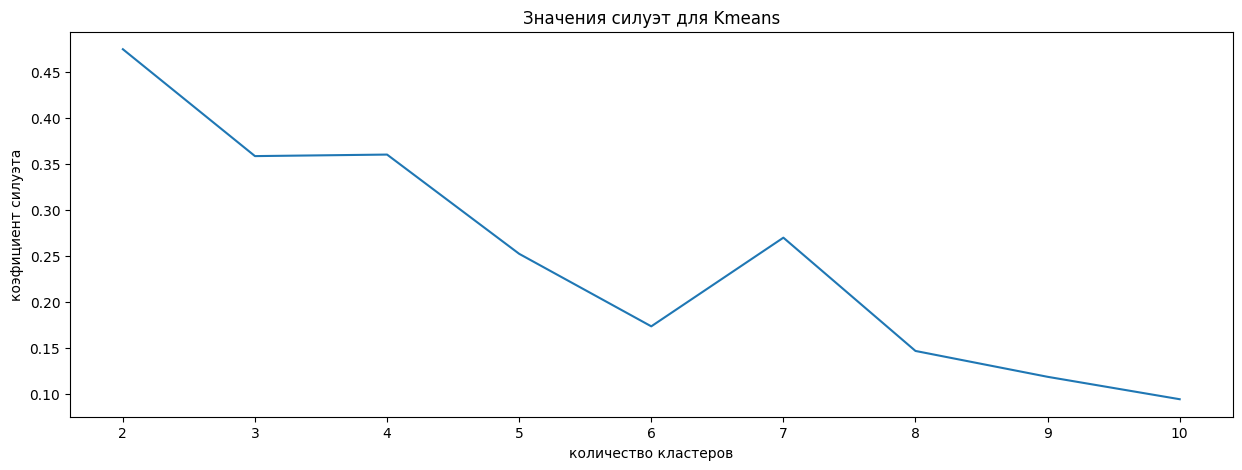

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
    x = range(2, 11),
    y = siluete_score,
)

ax.set(xlabel='количество кластеров', ylabel='коэфициент силуэта', title='Значения силуэт для Kmeans',);

<Axes: xlabel='cluster', ylabel='inertia'>

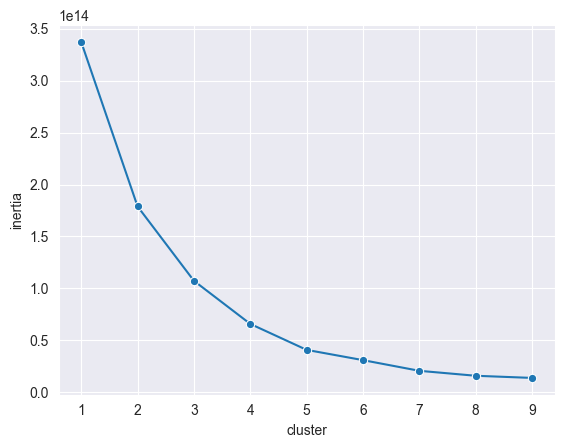

In [ ]:
def get_inertia(cluster_num, X):
# инициализируем алгоритм кластеризации
    k_means =  sklearn.cluster.KMeans(n_clusters=cluster_num, random_state=42)
# запускаем алгоритм k-means
    k_means.fit(X)
# находим значение инерции
    inertia = k_means.inertia_
# возвращаем значение инерции
    return inertia

# создадим пустой словарь, ключами будут инерция и количество кластеров
res = {"inertia": [], "cluster": []}

# выберем нужные данные 
X = data_cleared

# итерируемся по разным размерам кластеров (от 1 до 9) и сохраним значение инерции для каждого кластера
for cluster_num in range(1, 10):
# сохраняем значения
    res["inertia"].append(get_inertia(cluster_num, X))
    res["cluster"].append(cluster_num)

# сохраним в датафрейм значение инерции и количество кластеров
res_df = pd.DataFrame(res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=res_df, x="cluster", y="inertia", marker= "o")

In [ ]:
km = sklearn.cluster.KMeans(n_clusters=2, random_state=11)
km.fit(data_cleared)
# siluete_score.append(metrics.silhouette_score(rfm_table_processed, km.labels_, metric='euclidean'))
print(f'Максимальное количество клиентов в кластере - {max(np.unique_counts(km.labels_).counts)}')

Максимальное количество клиентов в кластере - 83


In [ ]:
pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()), ('t_sne', sklearn.manifold.TSNE(n_components=2, perplexity=50, random_state=100))])
data_processed = pipe.fit_transform(data_cleared)

In [ ]:
print(f'Значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE - {round(pipe[1].kl_divergence_, 2)}')

Значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE - 0.08


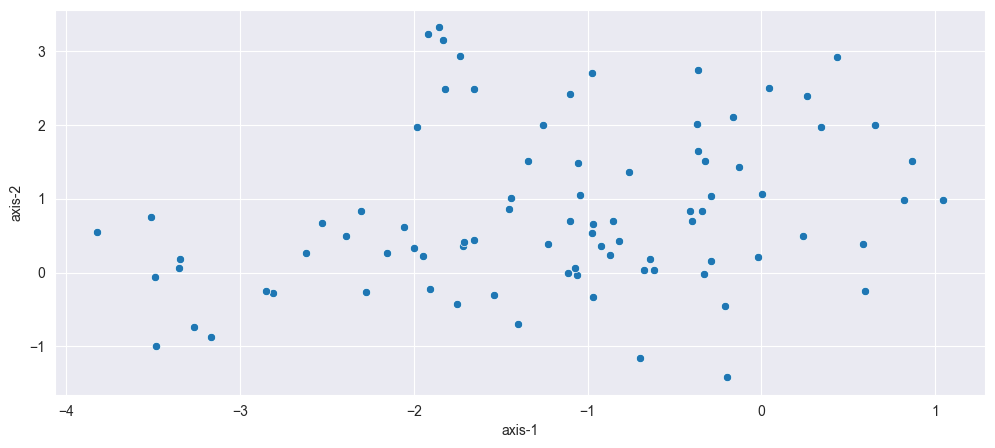

In [ ]:
data_processed = pd.DataFrame(data_processed, columns=['axis-1', 'axis-2'])
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2');

In [ ]:
siluete_score = []

for i in range(2, 9):
    km = sklearn.cluster.KMeans(n_clusters=i, random_state=42)
    y = km.fit(data_processed)
    siluete_score.append(sklearn.metrics.silhouette_score(data_processed, km.labels_, metric='euclidean'))

print(f'Максимальное значение коэффициента силлуэта - {round(max(siluete_score), 3)}')

Максимальное значение коэффициента силлуэта - 0.4020000100135803


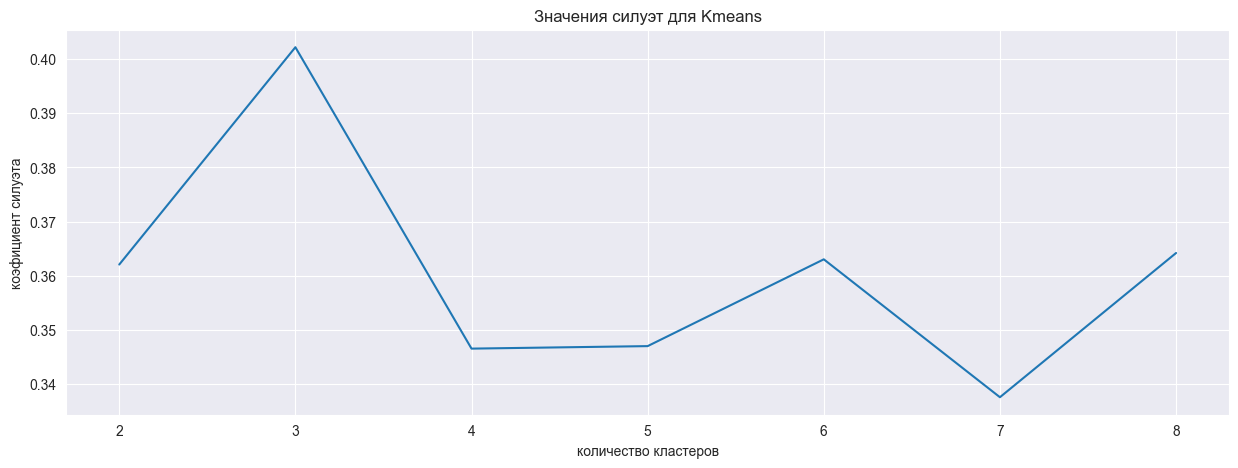

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
    x = range(2, 9),
    y = siluete_score,
)

ax.set(xlabel='количество кластеров', ylabel='коэфициент силуэта', title='Значения силуэт для Kmeans',);

In [ ]:
siluete_score = []

for i in range(3, 9):
    gm = sklearn.mixture.GaussianMixture(n_components=i, random_state=42)
    y = gm.fit_predict(rfm_table_processed)
    siluete_score.append(sklearn.metrics.silhouette_score(data_processed, y, metric='euclidean'))

print(f'Максимальное значение коэффициента силуэта - {round(max(siluete_score), 2)}')

NameError: name 'rfm_table_processed' is not defined

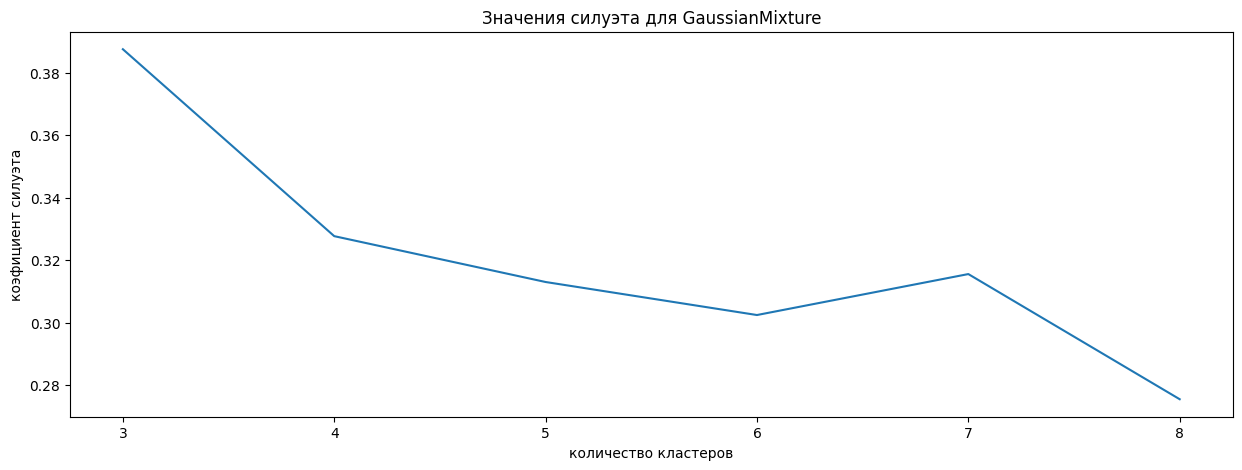

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
    x = range(3, 9),
    y = siluete_score
)

ax.set(xlabel='количество кластеров', ylabel='коэфициент силуэта', title='Значения силуэта для GaussianMixture',);

In [ ]:
siluete_score = []

for i in range(3, 9):
    ac = sklearn.cluster.AgglomerativeClustering(n_clusters=i)
    y = ac.fit_predict(rfm_table_processed)
    siluete_score.append(sklearn.metrics.silhouette_score(data_processed, y, metric='euclidean'))

print(f'Максимальное значение коэффициента силлуэта - {round(max(siluete_score), 2)}')

Максимальное значение коэффициента силлуэта - 0.3700000047683716


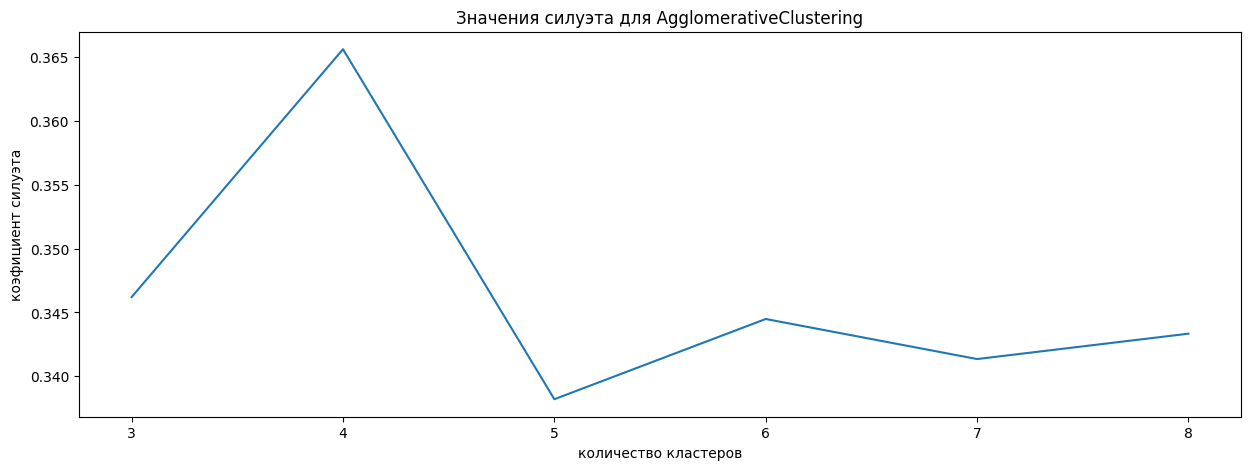

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
    x = range(3, 9),
    y = siluete_score
)

ax.set(xlabel='количество кластеров', ylabel='коэфициент силуэта', title='Значения силуэта для AgglomerativeClustering',);

In [ ]:
km = sklearn.cluster.KMeans(n_clusters=4, random_state=42)
km.fit(data_cleared)
# siluete_score.append(metrics.silhouette_score(rfm_table_processed, km.labels_, metric='euclidean'))
print(f'Максимальное количество клиентов в кластере - {max(np.unique_counts(km.labels_).counts)}')

Максимальное количество клиентов в кластере - 60


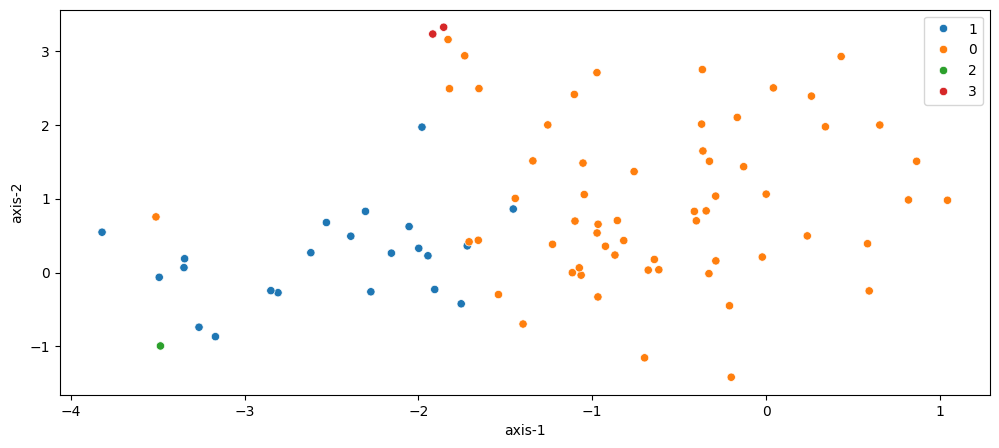

In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=data_processed, x='axis-1', y='axis-2', hue=km.labels_.astype('str'));

In [ ]:
view = pd.DataFrame(data = km.labels_.astype('str'), index = data.index)
print(view)

                          0
region                     
алтайский край            1
амурская обл              0
архангельская обл         0
астраханская обл          0
белгородская обл          0
...                      ..
чеченская республика      0
чувашская республика      0
чукотский авт округ       0
ямало-ненецкий авт округ  3
ярославская обл           0

[85 rows x 1 columns]


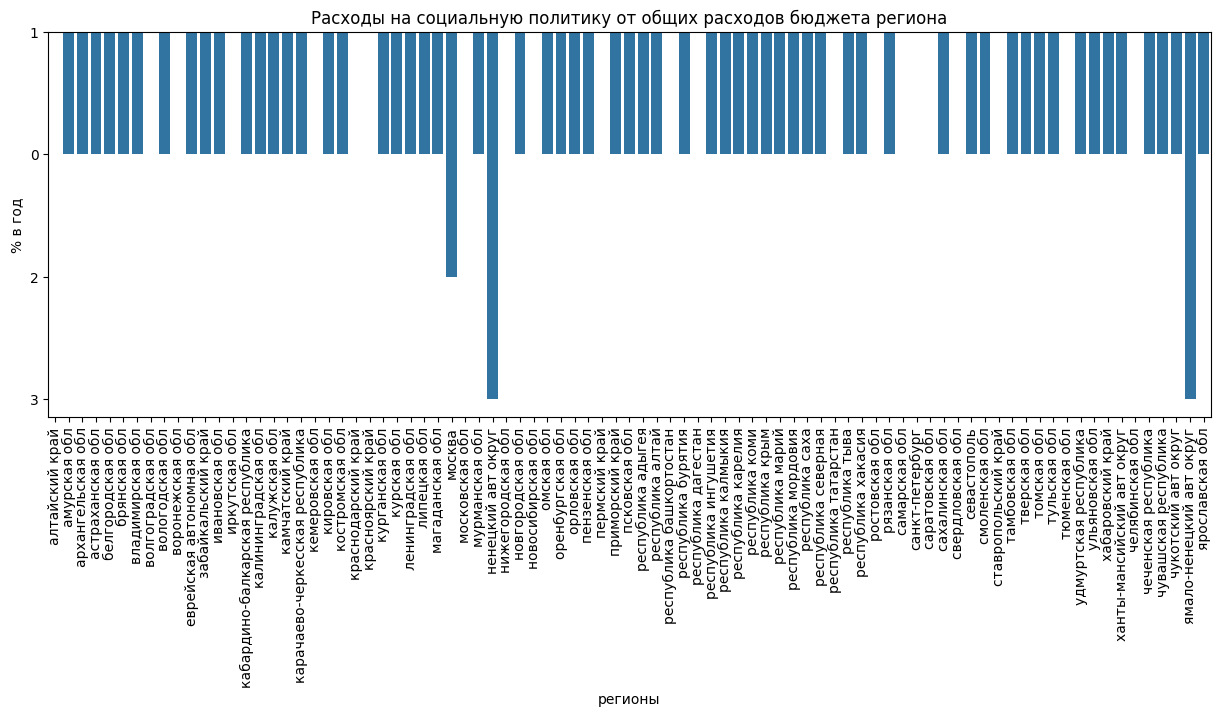

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    view
,
    x = view.index,
    y = view[0]

)
ax.set(xlabel='регионы', ylabel='% в год', title='Расходы на социальную политику от общих расходов бюджета региона',)
ax.tick_params(axis='x', rotation=90);